In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import scanpy as sc
import episcanpy as epi
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cloudpickle as pickle

import glob
import optuna
import os
import sklearn
import time
import string

from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import adjusted_mutual_info_score as AMI
from matplotlib.patches import Patch
from pathlib import Path
from scipy import io
from helps import *
import nmi
pd.set_option("display.precision", 12)
colors_to_use_pastel=[(0.5665516830630946, 0.5037138904751852, 0.5075215212500083),
 (0.9949012052279167, 0.7553237006975844, 0.5055095027008268),
 (0.6013710840316495, 0.6764106146805113, 0.9895579386673582),
 (0.998816092724718, 0.7071878014442006, 0.8979090191443285),
 (0.5429870427410571, 0.750719571440085, 0.6124765491924715),
 (0.5084695919264852, 0.5093366344721296, 0.9990436978593071),
 (0.8246194014837736, 0.9846839170837028, 0.5089892119497516),
 (0.5052972476002842, 0.5444186786858283, 0.7812964942323839),
 (0.5124601533942488, 0.9750384643760528, 0.9697621879182152),
 (0.9728598314959997, 0.5013134514042519, 0.8469604310077152)]

palette={alg : colors_to_use_pastel[i] for i,alg in enumerate(["ShareTopic","Mowgli","nSBM"])}

# Topics' agreement

## Peak/ADT

In [2]:
dfs={}
for dataset in ["PBMC","MouseSkin","BMMCMultiOme","HSPC"]:
    file=f"Datasets/{dataset}/SBM/25Runs_{dataset}_SBMs_Topics_Peak_NMI.tsv.gz"
    if os.path.isfile(file):
        dfs[dataset]=pd.read_csv(file, sep="\t", index_col=0)
        np.fill_diagonal(dfs[dataset].values, 25)
        dfs[dataset]=dfs[dataset]/25
for dataset in ["BMMCCite","Spleen"]:
    file=f"Datasets/{dataset}/SBM/25Runs_{dataset}_SBMs_Topics_ADT_NMI.tsv.gz"
    if os.path.isfile(file):
        dfs[dataset]=pd.read_csv(file, sep="\t", index_col=0)
        np.fill_diagonal(dfs[dataset].values, 25)
        dfs[dataset]=dfs[dataset]/25
dfs[dataset]

hSBM_ADT  nSBM_ADT_GEX   nSBM_ADT_mRNA  nSBM_ADT_lncRNA  \
hSBM_ADT                   1.0          0.42  0.677827243583   0.581549381963   
nSBM_ADT_GEX               NaN          1.00  0.300000000000   0.366666666667   
nSBM_ADT_mRNA              NaN           NaN  1.000000000000   0.549177840809   
nSBM_ADT_lncRNA            NaN           NaN             NaN   1.000000000000   
nSBM_ADT_mRNA_lncRNA       NaN           NaN             NaN              NaN   

                      nSBM_ADT_mRNA_lncRNA  
hSBM_ADT                    0.608046153009  
nSBM_ADT_GEX                0.280000000000  
nSBM_ADT_mRNA               0.625587431582  
nSBM_ADT_lncRNA             0.458927305213  
nSBM_ADT_mRNA_lncRNA        1.000000000000

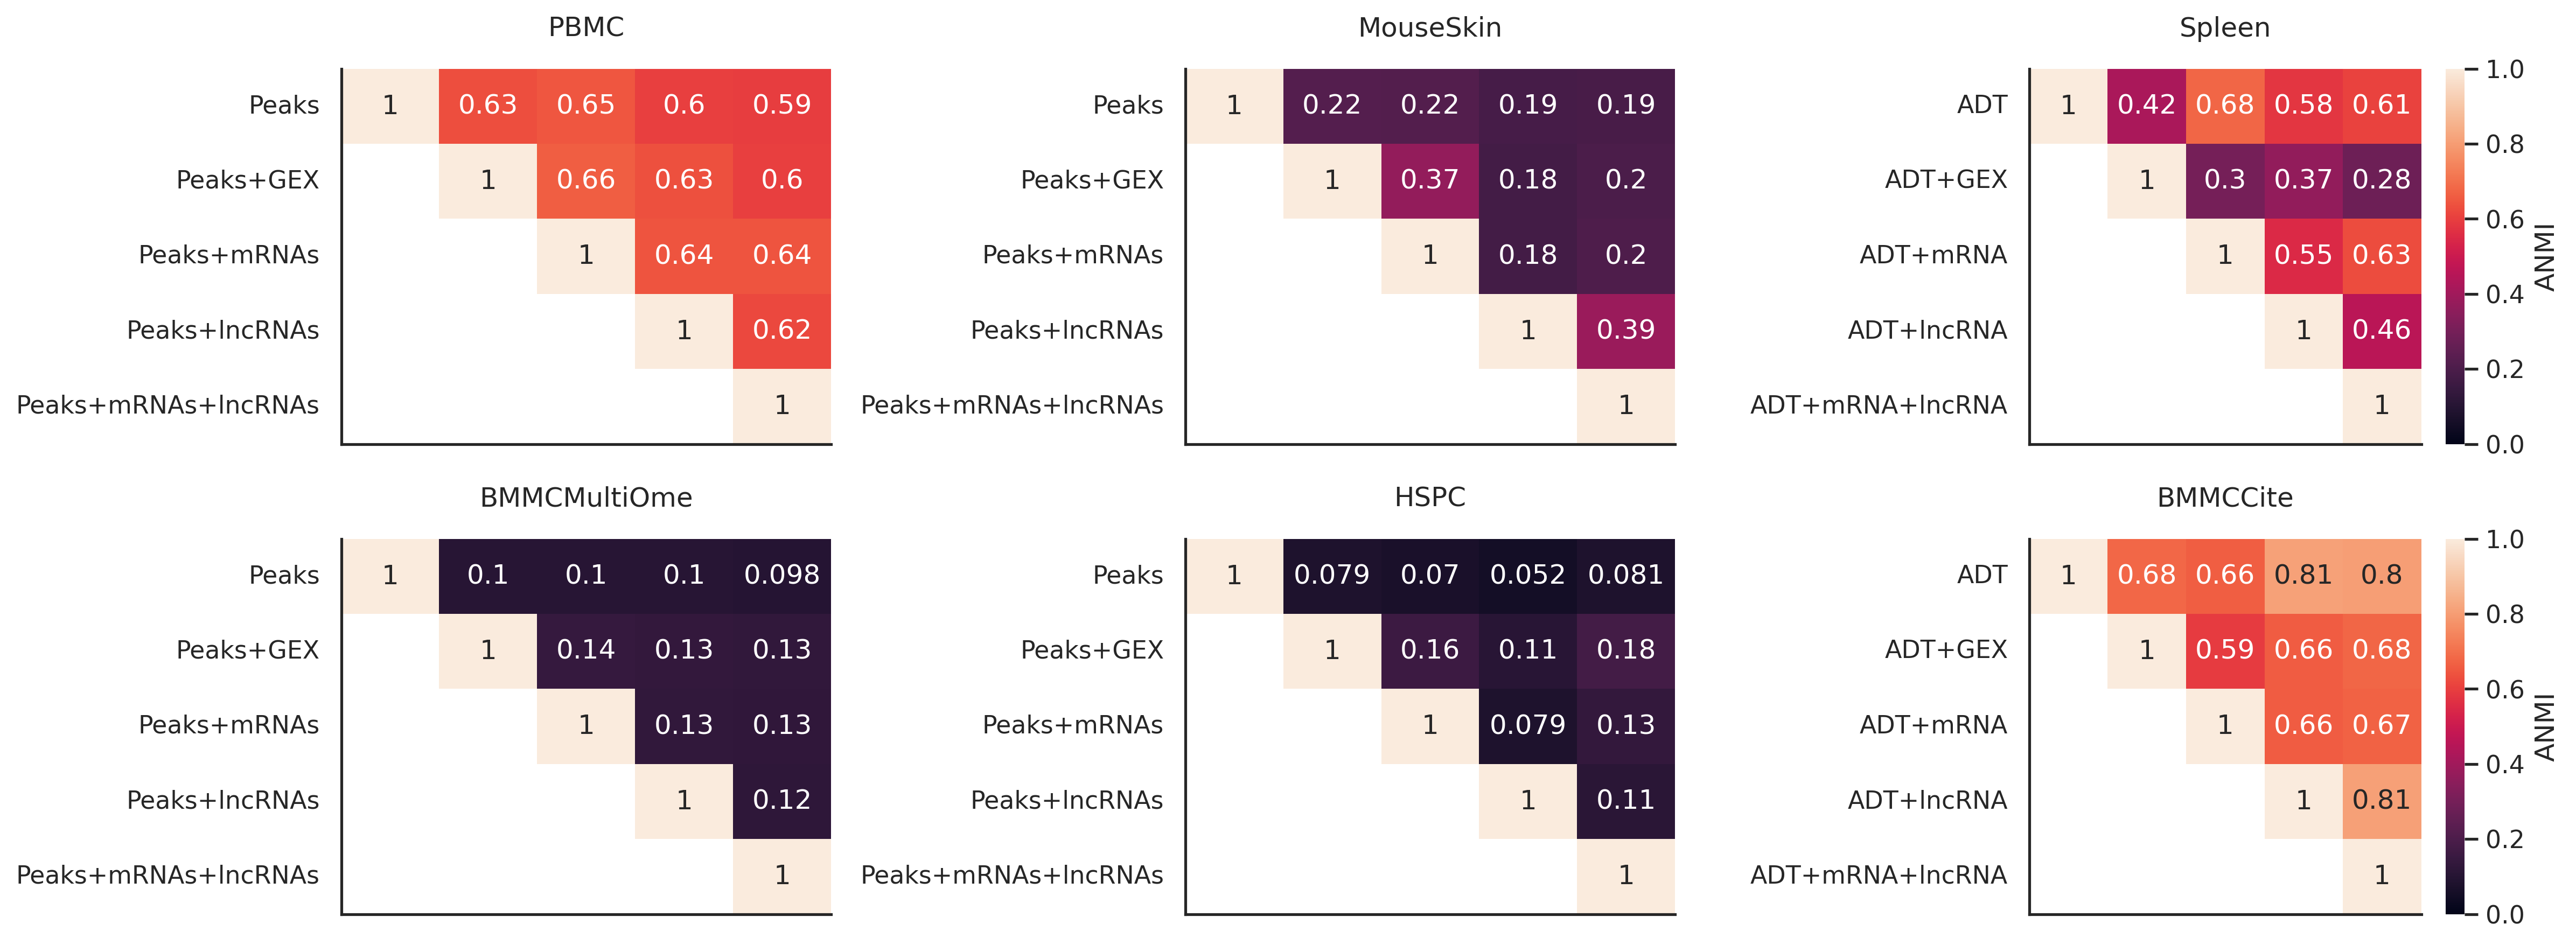

In [8]:
sns.set(style="ticks")
sns.set_style("white")

fig, axs = plt.subplots(2,3, figsize=(16,6), dpi=300)
axs=axs.flatten()

for l, dataset in enumerate(["PBMC","MouseSkin", "Spleen","BMMCMultiOme","HSPC","BMMCCite"]):
    bar=True if l in [2,5] else False
    if dataset in ["BMMCCite", "Spleen"]:
        order=["ADT", "ADT+GEX", "ADT+mRNA", "ADT+lncRNA", "ADT+mRNA+lncRNA"]
    else:
        order=["Peaks", "Peaks+GEX", "Peaks+mRNAs", "Peaks+lncRNAs", "Peaks+mRNAs+lncRNAs"]
    sns.heatmap(dfs[dataset], annot=True, cbar_kws={"label" : "ANMI"}, annot_kws={"size": 12},  ax=axs[l], cbar=bar, vmin=0, vmax=1)
    axs[l].set_yticks(axs[l].get_yticks(),order)
    axs[l].set_title(dataset, y=1.05)
    axs[l].set_xticks([])
    axs[l].spines['top'].set_visible(False)
    axs[l].spines['right'].set_visible(False)  
    axs[l].spines['bottom'].set_visible(True)
    axs[l].spines['left'].set_visible(True)  
#    axs[l].set_yticks(rotation=0) 
fig.tight_layout()
plt.savefig(f"Figures/Figure1.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

In [81]:
dfs={}
for dataset in ["PBMC","MouseSkin","BMMCMultiOme","HSPC"]:
    file=f"Datasets/{dataset}/SBM/25Runs_{dataset}_SBMs_Topics_Peak_NMI.tsv.gz"
    if os.path.isfile(file):
        dfs[dataset]=pd.read_csv(file, sep="\t", index_col=0)
        np.fill_diagonal(dfs[dataset].values, 25)
        dfs[dataset]=dfs[dataset]/25
for dataset in ["BMMCCite","Spleen"]:
    file=f"Datasets/{dataset}/SBM/25Runs_{dataset}_SBMs_Topics_ADT_NMI.tsv.gz"
    if os.path.isfile(file):
        dfs[dataset]=pd.read_csv(file, sep="\t", index_col=0)
        np.fill_diagonal(dfs[dataset].values, 25)
        dfs[dataset]=dfs[dataset]/25
dfs[dataset]

hSBM_ADT  nSBM_ADT_GEX   nSBM_ADT_mRNA  nSBM_ADT_lncRNA  \
hSBM_ADT                   1.0          0.42  0.677827243583   0.581549381963   
nSBM_ADT_GEX               NaN          1.00  0.300000000000   0.366666666667   
nSBM_ADT_mRNA              NaN           NaN  1.000000000000   0.549177840809   
nSBM_ADT_lncRNA            NaN           NaN             NaN   1.000000000000   
nSBM_ADT_mRNA_lncRNA       NaN           NaN             NaN              NaN   

                      nSBM_ADT_mRNA_lncRNA  
hSBM_ADT                    0.608046153009  
nSBM_ADT_GEX                0.280000000000  
nSBM_ADT_mRNA               0.625587431582  
nSBM_ADT_lncRNA             0.458927305213  
nSBM_ADT_mRNA_lncRNA        1.000000000000

In [82]:
adatas={}
for dataset in ["PBMC","MouseSkin","BMMCMultiOme","HSPC"]:
    adatas[dataset]=sc.read_h5ad(f"Datasets/{dataset}/CM/{dataset}_Peak_Def.h5ad")

In [83]:
for dataset in ["BMMCCite","Spleen"]:
    adatas[dataset]=sc.read_h5ad(f"Datasets/{dataset}/CM/{dataset}_ADT_Def.h5ad")

In [84]:
adatas.keys()

dict_keys(['PBMC', 'MouseSkin', 'BMMCMultiOme', 'HSPC', 'BMMCCite', 'Spleen'])

In [85]:
corrs=[]
for dataset in ["PBMC","MouseSkin","BMMCMultiOme","HSPC", "BMMCCite","Spleen"]:
    corrs.append([np.log10(adatas[dataset].shape[1]), dfs[dataset].mean().mean(), dataset])
corrs=np.array(corrs).T
corrs=pd.DataFrame(corrs, index=["Size","Agreement","Dataset"]).T
corrs["Size"]=corrs["Size"].astype(float).round(decimals=2)
corrs["Agreement"]=corrs["Agreement"].astype(float).round(decimals=3)
corrs["Technique"]=["MultiOme","MultiOme","MultiOme","MultiOme","Cite","Cite"]
corrs

Size  Agreement       Dataset Technique
0  4.28      0.799          PBMC  MultiOme
1  4.49      0.584     MouseSkin  MultiOme
2  4.50      0.521  BMMCMultiOme  MultiOme
3  4.31      0.512          HSPC  MultiOme
4  2.13      0.833      BMMCCite      Cite
5  2.32      0.718        Spleen      Cite

In [86]:
stats=scipy.stats.linregress(corrs["Size"], corrs["Agreement"])
stats

LinregressResult(slope=-0.08400578604773486, intercept=0.9696079111052663, rvalue=-0.6700532874636399, pvalue=0.14533745277200916, stderr=0.046532558184372304, intercept_stderr=0.1774185618128691)

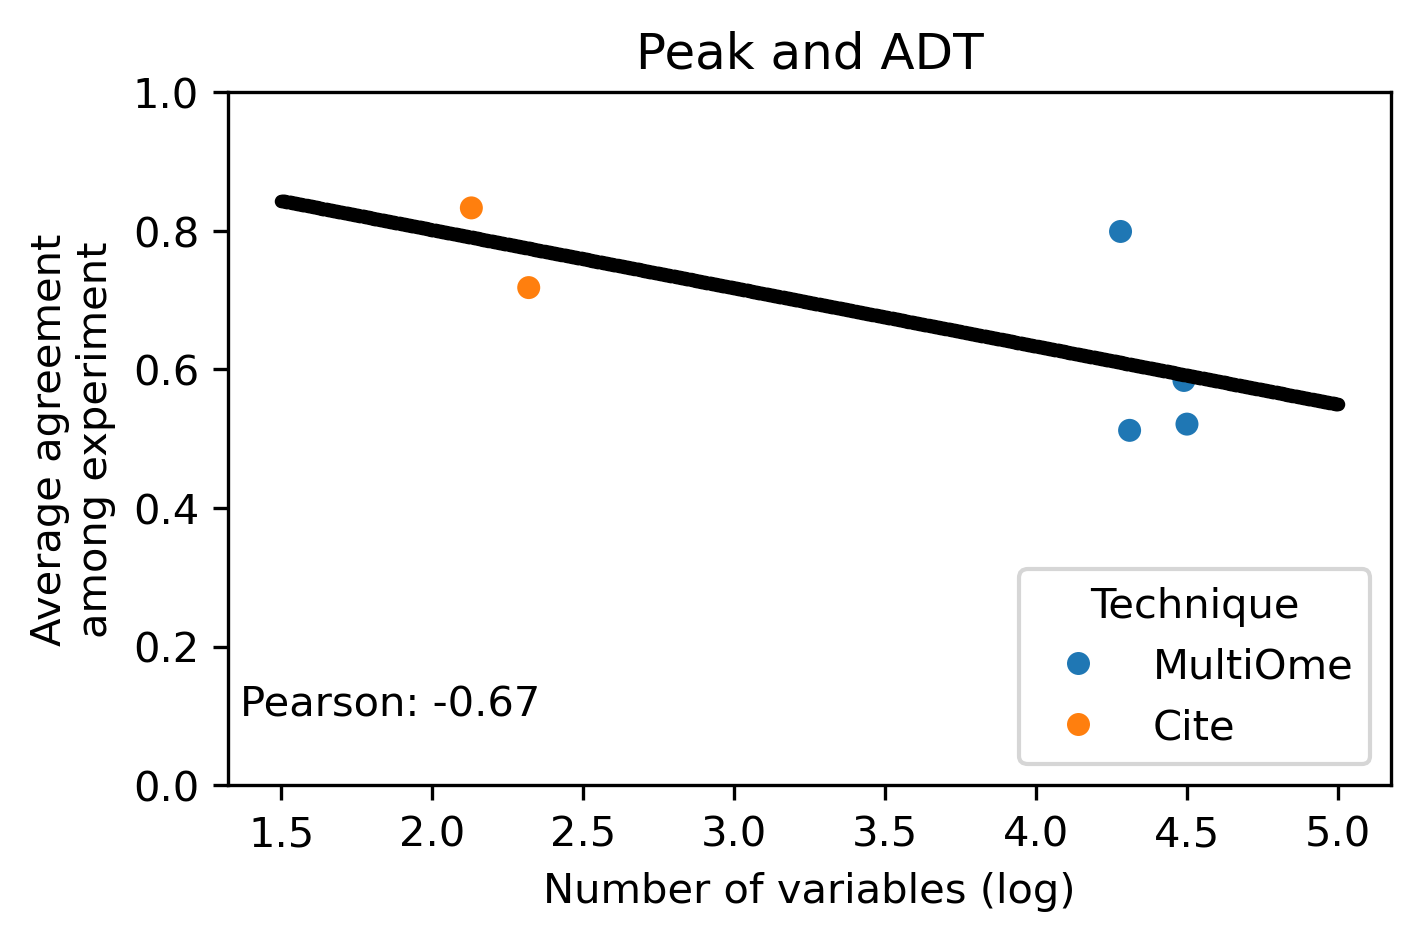

In [87]:
fig, ax = plt.subplots(1,1, figsize=(5,3), dpi=300)
plot=sns.scatterplot(data=corrs, x="Size", y="Agreement", hue="Technique", ax=ax)
sns.move_legend(plot, loc="lower right")
ax.set_xlabel("Number of variables (log)")
ax.set_ylabel("Average agreement\namong experiment")
stats=scipy.stats.linregress(corrs["Size"], corrs["Agreement"])
ax.annotate(f"Pearson: {str(np.around(stats[2], decimals=3))}", xy=(0.01, 0.1), xycoords="axes fraction")
ax.scatter(x=np.linspace(1.5,5,1000), y=np.linspace(1.5,5,1000)*stats[0]+stats[1], color="black", s=5)
ax.set_ylim([0,1])
ax.set_title("Peak and ADT")
plt.show()

## mRNA

In [6]:
dfs={}
for dataset in ["Spleen", "PBMC","MouseSkin","BMMCCite","BMMCMultiOme","HSPC"]:
    file=f"Datasets/{dataset}/SBM/25Runs_{dataset}_SBMs_Topics_mRNA_NMI.tsv.gz"
    if os.path.isfile(file):
        dfs[dataset]=pd.read_csv(file, sep="\t", index_col=0)
        np.fill_diagonal(dfs[dataset].values, 25)
        dfs[dataset]=dfs[dataset]/25
       # dfs[dataset]=(dfs[dataset]-dfs[dataset].min())/(dfs[dataset].max()-dfs[dataset].min())
dfs[dataset]

hSBM_mRNA  nSBM_Peak_mRNA  nSBM_mRNA_lncRNA  \
hSBM_mRNA                    1.0  0.001565204473    0.001586874237   
nSBM_Peak_mRNA               NaN  1.000000000000    0.007449412210   
nSBM_mRNA_lncRNA             NaN             NaN    1.000000000000   
nSBM_Peak_mRNA_lncRNA        NaN             NaN               NaN   

                       nSBM_Peak_mRNA_lncRNA  
hSBM_mRNA                     0.003414400763  
nSBM_Peak_mRNA                0.032541385339  
nSBM_mRNA_lncRNA              0.022926448285  
nSBM_Peak_mRNA_lncRNA         1.000000000000

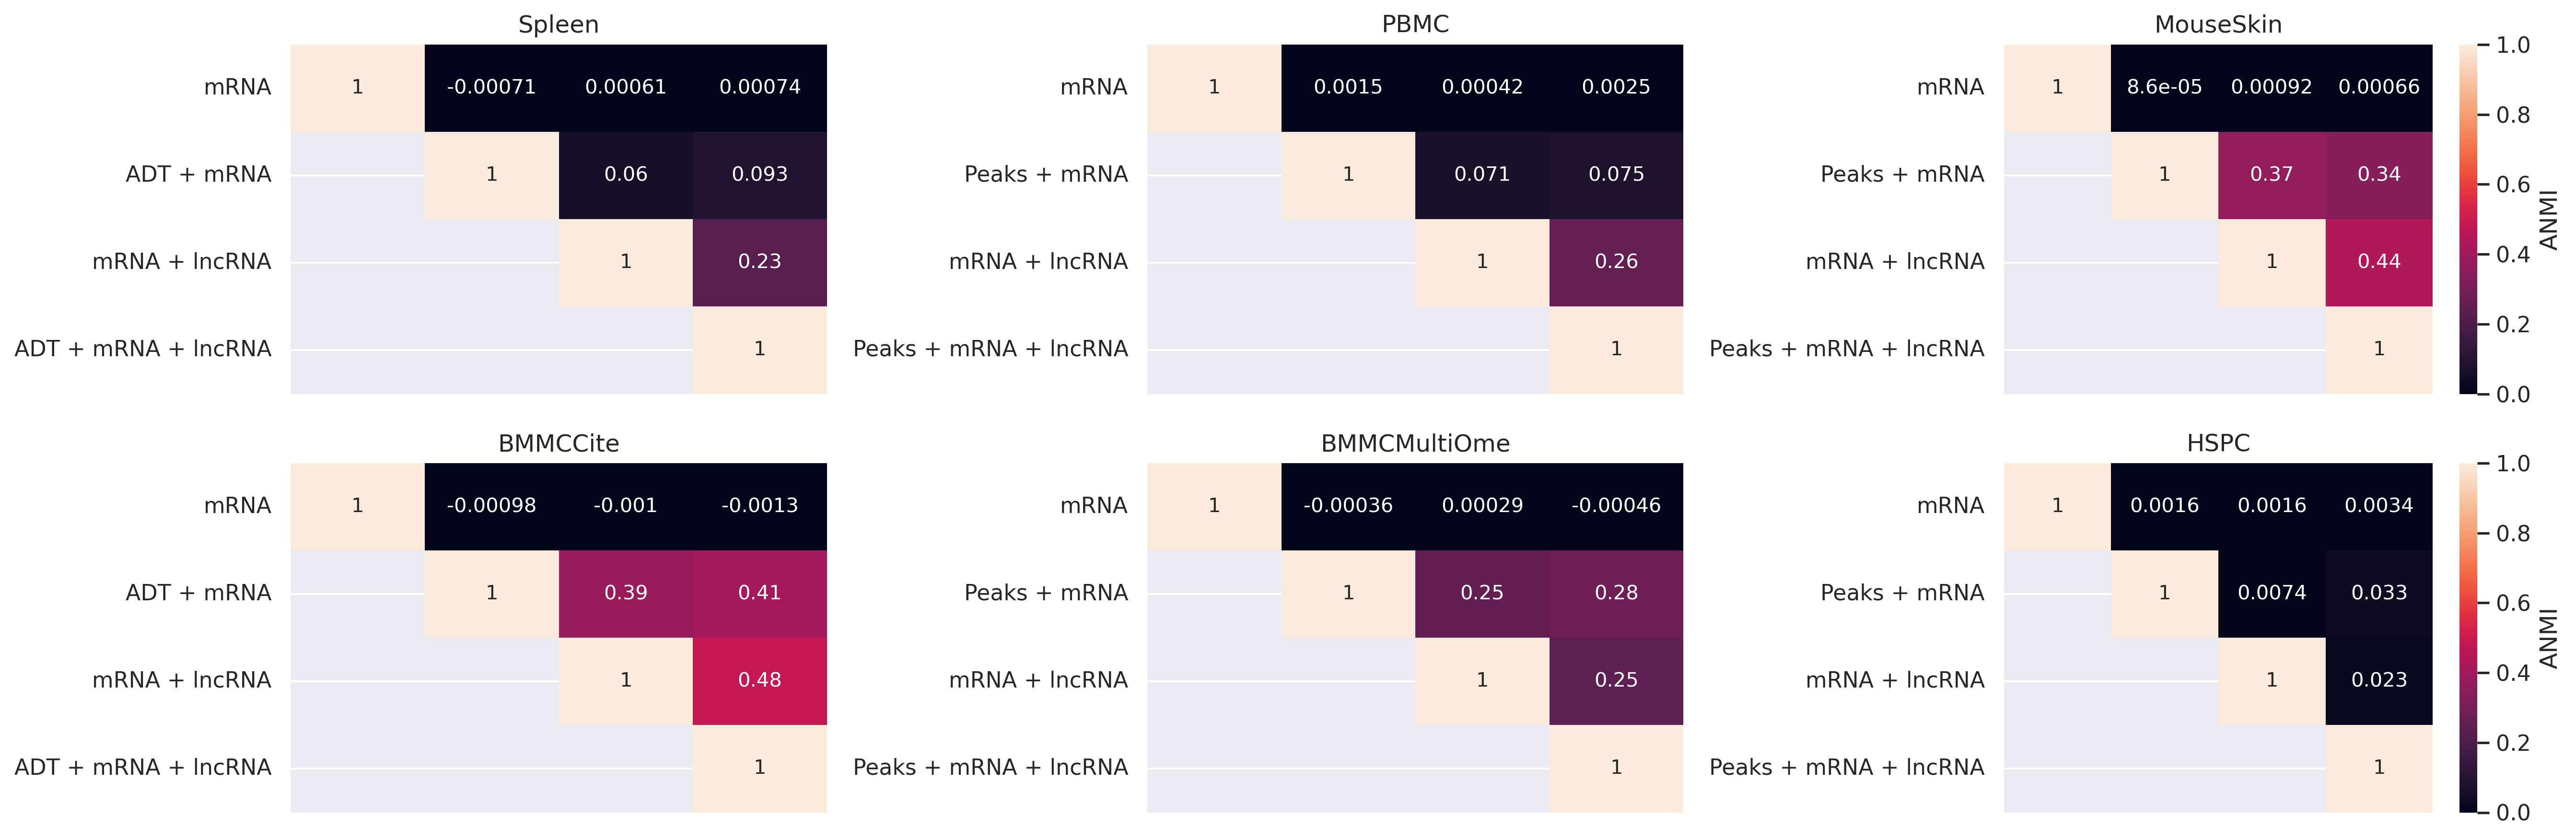

In [7]:
sns.set(style="ticks")
sns.set_style("darkgrid")

fig, axs = plt.subplots(2,3, figsize=(18,6), dpi=300)
axs=axs.flatten()

for l, dataset in enumerate(["Spleen", "PBMC","MouseSkin","BMMCCite","BMMCMultiOme","HSPC"]):
    bar=True if l in [2,5] else False
    if dataset in ["BMMCCite", "Spleen"]:
        order=["mRNA", "ADT+mRNA", "mRNA+lncRNA", "ADT+mRNA+lncRNA"]
    else:
        order=["mRNA", "Peaks+mRNA", "mRNA+lncRNA", "Peaks+mRNA+lncRNA"]
    sns.heatmap(dfs[dataset], annot=True, cbar_kws={"label" : "ANMI"}, annot_kws={"size": 10},  ax=axs[l], cbar=bar, vmin=0, vmax=1)
    axs[l].set_yticks(axs[l].get_yticks(),order)
    axs[l].set_title(dataset)
    axs[l].set_xticks([])
#    axs[l].set_yticks(rotation=0) 
fig.tight_layout()
plt.savefig(f"Figures/mRNA_Topics_Agreement_25Runs.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

In [74]:
dfs={}
for dataset in ["PBMC","MouseSkin","BMMCMultiOme","HSPC"]:
    file=f"Datasets/{dataset}/SBM/25Runs_{dataset}_SBMs_Topics_mRNA_NMI.tsv.gz"
    if os.path.isfile(file):
        dfs[dataset]=pd.read_csv(file, sep="\t", index_col=0)
        np.fill_diagonal(dfs[dataset].values, 25)
        dfs[dataset]=dfs[dataset]/25
for dataset in ["BMMCCite","Spleen"]:
    file=f"Datasets/{dataset}/SBM/25Runs_{dataset}_SBMs_Topics_mRNA_NMI.tsv.gz"
    if os.path.isfile(file):
        dfs[dataset]=pd.read_csv(file, sep="\t", index_col=0)
        np.fill_diagonal(dfs[dataset].values, 25)
        dfs[dataset]=dfs[dataset]/25
dfs[dataset]

hSBM_mRNA   nSBM_ADT_mRNA  nSBM_mRNA_lncRNA  \
hSBM_mRNA                   1.0 -0.000711793601    0.000614164149   
nSBM_ADT_mRNA               NaN  1.000000000000    0.060462397117   
nSBM_mRNA_lncRNA            NaN             NaN    1.000000000000   
nSBM_ADT_mRNA_lncRNA        NaN             NaN               NaN   

                      nSBM_ADT_mRNA_lncRNA  
hSBM_mRNA                   0.000736876759  
nSBM_ADT_mRNA               0.092924309292  
nSBM_mRNA_lncRNA            0.227486044441  
nSBM_ADT_mRNA_lncRNA        1.000000000000

In [75]:
adatas={}
for dataset in ["PBMC","MouseSkin","BMMCMultiOme","HSPC"]:
    adatas[dataset]=sc.read_h5ad(f"Datasets/{dataset}/CM/{dataset}_mRNA_Def.h5ad")

In [76]:
for dataset in ["BMMCCite","Spleen"]:
    adatas[dataset]=sc.read_h5ad(f"Datasets/{dataset}/CM/{dataset}_mRNA_Def.h5ad")

In [77]:
adatas.keys()

dict_keys(['PBMC', 'MouseSkin', 'BMMCMultiOme', 'HSPC', 'BMMCCite', 'Spleen'])

In [78]:
corrs=[]
for dataset in ["PBMC","MouseSkin","BMMCMultiOme","HSPC", "BMMCCite","Spleen"]:
    corrs.append([np.log10(adatas[dataset].shape[1]), dfs[dataset].mean().mean(), dataset])
corrs=np.array(corrs).T
corrs=pd.DataFrame(corrs, index=["Size","Agreement","Dataset"]).T
corrs["Size"]=corrs["Size"].astype(float).round(decimals=2)
corrs["Agreement"]=corrs["Agreement"].astype(float).round(decimals=3)
corrs["Technique"]=["MultiOme","MultiOme","MultiOme","MultiOme","Cite","Cite"]
corrs

Size  Agreement       Dataset Technique
0  3.45      0.548          PBMC  MultiOme
1  3.71      0.601     MouseSkin  MultiOme
2  3.10      0.575  BMMCMultiOme  MultiOme
3  3.74      0.525          HSPC  MultiOme
4  3.60      0.609      BMMCCite      Cite
5  3.60      0.546        Spleen      Cite

In [79]:
stats=scipy.stats.linregress(corrs["Size"], corrs["Agreement"])
stats

LinregressResult(slope=-0.011374009128032643, intercept=0.6075214989190487, rvalue=-0.08043605124500343, pvalue=0.879606132082785, stderr=0.07047309360428809, intercept_stderr=0.2494657927542265)

In [80]:
fig, ax = plt.subplots(1,1, figsize=(5,3), dpi=300)
plot=sns.scatterplot(data=corrs, x="Size", y="Agreement", hue="Technique", ax=ax)
sns.move_legend(plot, loc="lower right")
ax.set_xlabel("Number of variables (log)")
ax.set_ylabel("Average agreement\namong experiment")
stats=scipy.stats.linregress(corrs["Size"], corrs["Agreement"])
ax.annotate(f"Pearson: {str(np.around(stats[2], decimals=3))}", xy=(0.01, 0.1), xycoords="axes fraction")
ax.scatter(x=np.linspace(2.5,4,10000), y=np.linspace(2.5,4,10000)*stats[0]+stats[1], color="black", s=0.1)
ax.set_ylim([0,1])
ax.set_title("mRNA")
plt.show()

## lncRNA

In [8]:
dfs={}
for dataset in ["Spleen", "PBMC","MouseSkin","BMMCCite","BMMCMultiOme","HSPC"]:
    file=f"Datasets/{dataset}/SBM/25Runs_{dataset}_SBMs_Topics_lncRNA_NMI.tsv.gz"
    if os.path.isfile(file):
        dfs[dataset]=pd.read_csv(file, sep="\t", index_col=0)
        np.fill_diagonal(dfs[dataset].values, 25)
        dfs[dataset]=dfs[dataset]/25
dfs[dataset]

hSBM_lncRNA  nSBM_Peak_lncRNA  nSBM_mRNA_lncRNA  \
hSBM_lncRNA                    1.0    0.274064539687    0.332992154177   
nSBM_Peak_lncRNA               NaN    1.000000000000    0.121395073279   
nSBM_mRNA_lncRNA               NaN               NaN    1.000000000000   
nSBM_Peak_mRNA_lncRNA          NaN               NaN               NaN   

                       nSBM_Peak_mRNA_lncRNA  
hSBM_lncRNA                   0.307994127088  
nSBM_Peak_lncRNA              0.230166903347  
nSBM_mRNA_lncRNA              0.163123478060  
nSBM_Peak_mRNA_lncRNA         1.000000000000

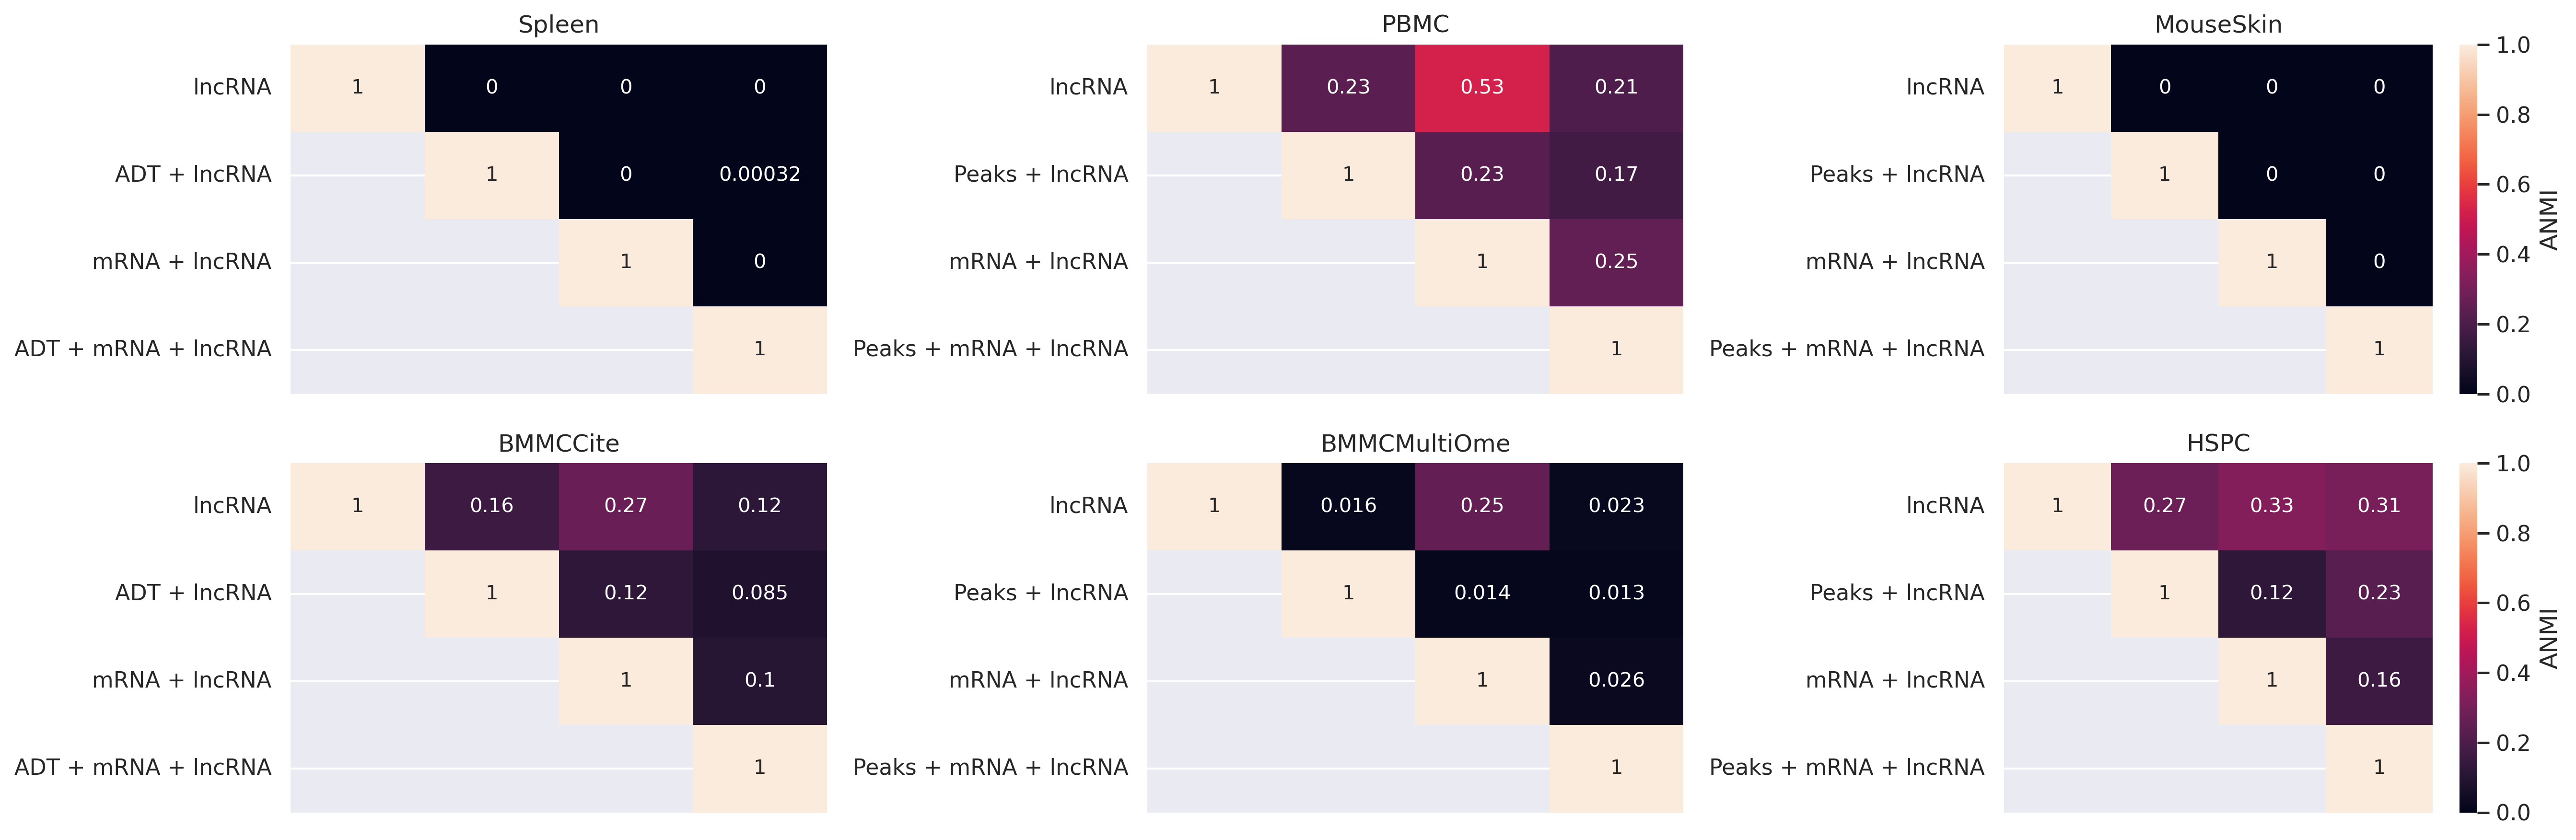

In [9]:
sns.set(style="ticks")
sns.set_style("darkgrid")

fig, axs = plt.subplots(2,3, figsize=(18,6), dpi=300)
axs=axs.flatten()

for l, dataset in enumerate(["Spleen", "PBMC","MouseSkin","BMMCCite","BMMCMultiOme","HSPC"]):
    bar=True if l in [2,5] else False
    if dataset in ["BMMCCite", "Spleen"]:
        order=["lncRNA", "ADT+lncRNA", "mRNA+lncRNA", "ADT+mRNA+lncRNA"]
    else:
        order=["lncRNA", "Peaks+lncRNA", "mRNA+lncRNA", "Peaks+mRNA+lncRNA"]
    sns.heatmap(dfs[dataset], annot=True, cbar_kws={"label" : "ANMI"}, annot_kws={"size": 10},  ax=axs[l], cbar=bar, vmin=0, vmax=1)
    axs[l].set_yticks(axs[l].get_yticks(),order)
    axs[l].set_title(dataset)
    axs[l].set_xticks([])
#    axs[l].set_yticks(rotation=0) 
fig.tight_layout()
plt.savefig(f"Figures/lncRNA_Topics_Agreement_25Runs.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

In [66]:
dfs={}
for dataset in ["PBMC","MouseSkin","BMMCMultiOme","HSPC"]:
    file=f"Datasets/{dataset}/SBM/25Runs_{dataset}_SBMs_Topics_lncRNA_NMI.tsv.gz"
    if os.path.isfile(file):
        dfs[dataset]=pd.read_csv(file, sep="\t", index_col=0)
        np.fill_diagonal(dfs[dataset].values, 25)
        dfs[dataset]=dfs[dataset]/25
for dataset in ["BMMCCite","Spleen"]:
    file=f"Datasets/{dataset}/SBM/25Runs_{dataset}_SBMs_Topics_lncRNA_NMI.tsv.gz"
    if os.path.isfile(file):
        dfs[dataset]=pd.read_csv(file, sep="\t", index_col=0)
        np.fill_diagonal(dfs[dataset].values, 25)
        dfs[dataset]=dfs[dataset]/25
dfs[dataset]

hSBM_lncRNA  nSBM_ADT_lncRNA  nSBM_mRNA_lncRNA  \
hSBM_lncRNA                   1.0              0.0               0.0   
nSBM_ADT_lncRNA               NaN              1.0               0.0   
nSBM_mRNA_lncRNA              NaN              NaN               1.0   
nSBM_ADT_mRNA_lncRNA          NaN              NaN               NaN   

                      nSBM_ADT_mRNA_lncRNA  
hSBM_lncRNA                 0.000000000000  
nSBM_ADT_lncRNA             0.000323697846  
nSBM_mRNA_lncRNA            0.000000000000  
nSBM_ADT_mRNA_lncRNA        1.000000000000

In [67]:
adatas={}
for dataset in ["PBMC","MouseSkin","BMMCMultiOme","HSPC"]:
    adatas[dataset]=sc.read_h5ad(f"Datasets/{dataset}/CM/{dataset}_lncRNA_Def.h5ad")

In [68]:
for dataset in ["BMMCCite","Spleen"]:
    adatas[dataset]=sc.read_h5ad(f"Datasets/{dataset}/CM/{dataset}_lncRNA_Def.h5ad")

In [69]:
adatas.keys()

dict_keys(['PBMC', 'MouseSkin', 'BMMCMultiOme', 'HSPC', 'BMMCCite', 'Spleen'])

In [70]:
corrs=[]
for dataset in ["PBMC","MouseSkin","BMMCMultiOme","HSPC", "BMMCCite","Spleen"]:
    corrs.append([np.log10(adatas[dataset].shape[1]), dfs[dataset].mean().mean(), dataset])
corrs=np.array(corrs).T
corrs=pd.DataFrame(corrs, index=["Size","Agreement","Dataset"]).T
corrs["Size"]=corrs["Size"].astype(float).round(decimals=2)
corrs["Agreement"]=corrs["Agreement"].astype(float).round(decimals=3)
corrs["Technique"]=["MultiOme","MultiOme","MultiOme","MultiOme","Cite","Cite"]
corrs

Size  Agreement       Dataset Technique
0  3.37      0.652          PBMC  MultiOme
1  3.42      0.521     MouseSkin  MultiOme
2  2.69      0.549  BMMCMultiOme  MultiOme
3  3.35      0.637          HSPC  MultiOme
4  2.77      0.593      BMMCCite      Cite
5  2.90      0.521        Spleen      Cite

In [71]:
stats=scipy.stats.linregress(corrs["Size"], corrs["Agreement"])
stats

LinregressResult(slope=0.06311919971073889, intercept=0.3842158008918884, rvalue=0.36526916017208133, pvalue=0.4764636502123571, stderr=0.08043080624344087, intercept_stderr=0.2491944893582736)

In [73]:
fig, ax = plt.subplots(1,1, figsize=(5,3), dpi=300)
plot=sns.scatterplot(data=corrs, x="Size", y="Agreement", hue="Technique", ax=ax)
sns.move_legend(plot, loc="lower right")
ax.set_xlabel("Number of variables (log)")
ax.set_ylabel("Average agreement\namong experiment")
stats=scipy.stats.linregress(corrs["Size"], corrs["Agreement"])
ax.annotate(f"Pearson: {str(np.around(stats[2], decimals=3))}", xy=(0.01, 0.1), xycoords="axes fraction")
ax.scatter(x=np.linspace(2.5,4,10000), y=np.linspace(2.5,4,10000)*stats[0]+stats[1], color="black", s=0.1)
ax.set_ylim([0,1])
ax.set_title("lncRNA")
plt.show()

# Motif

In [ ]:
dataset="PBMC"
peak=sc.read_h5ad(f"Datasets/{dataset}/CM/{dataset}_Peak_Def.h5ad").var
peak

In [5]:
dfs=pd.DataFrame(data=["PBMC","HumanBrain","LymphomaB","BMMCMultiOme","MouseBrain","HSPC"])
exps=["hSBM_Peak","nSBM_Peak_GEX", "nSBM_Peak_mRNA", "nSBM_Peak_lncRNA"]
hs1="../AnnotRef/hs/T2T/chm13v2.0.fa"
dfs["Genome"]=[hs1,hs1,"hg38","hg38","mm10","hg38"]
dfs

0                           Genome
0          PBMC  ../AnnotRef/hs/T2T/chm13v2.0.fa
1    HumanBrain  ../AnnotRef/hs/T2T/chm13v2.0.fa
2     LymphomaB                             hg38
3  BMMCMultiOme                             hg38
4    MouseBrain                             mm10
5          HSPC                             hg38

In [ ]:
for dataset, genome in zip(dfs[0][:1], dfs["Genome"][:1]):
    for l in range(0, 4)[:1]:
        file=f'Datasets/{dataset}/SBM/hSBM_Peak/{dataset}_hSBM_Peak_CellType_topics_level_{l}.txt'
        if os.path.isfile(file):
            with open(file) as f:
                d = json.load(f)
            d1={key : flat_list(np.array(d[key])[:,:1].tolist()).tolist() for key in d.keys()}
            temp=pd.DataFrame.from_dict(d1, orient="index")
            if len(temp.columns) > 1:
                temp.columns=[f"Topic_{col}" for col in range(0, len(temp.columns))]
                for col in temp.columns[:1]:
                    path=f"Datasets/{dataset}/SBM/hSBM_Peak/MotifAnalysis/{col}"
                    Path(path).mkdir(parents=True, exist_ok=True)
                    coords=list(temp[col].dropna())
                    if len(coords) > 0:
                        pd.DataFrame([g.split("_") for g in list(coords)]).to_csv(f"{path}/tempcoords.tsv", sep="\t", header=None, index=None)
                        os.system(f"findMotifsGenome.pl {path}/tempcoords.tsv {genome} {path} -p 10")
                        os.system(f"rm {path}/tempcoords.tsv")


	Position file = Datasets/PBMC/SBM/hSBM_Peak/MotifAnalysis/Topic_0/tempcoords.tsv
	Genome = ../AnnotRef/hs/T2T/chm13v2.0.fa
	Output Directory = Datasets/PBMC/SBM/hSBM_Peak/MotifAnalysis/Topic_0
	Using 10 CPUs
	Using Custom Genome
	Peak/BED file conversion summary:
		BED/Header formatted lines: 164
		peakfile formatted lines: 0

	Peak File Statistics:
		Total Peaks: 164
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Background files for 200 bp fragments found.
	Custom genome sequence file: ../AnnotRef/hs/T2T/chm13v2.0.fa

	Extracting sequences from file: ../AnnotRef/hs/T2T/chm13v2.0.fa
	Looking for peak sequences in a single file (../AnnotRef/hs/T2T/chm13v2.0.fa)
	Extracting 27 sequences from chr1
	Extracting 27 sequences from chr2
	Extracting 15 sequences from chr3
	Extracting 11 sequences fr

In [21]:
dataset="PBMC"
run=0
file = f"Datasets/{dataset}/ShareTopic/ShareTopic_Peak_GEX/Runs/Run{run}/{dataset}_ShareTopic_Peak_GEX_Topic_Cell.tsv.gz"
df=pd.read_csv(file, index_col=0, sep="\t").T
df

Topic_0      Topic_1      Topic_2      Topic_3  \
CCACACAAGGCAATAG-1  0.2011950900  0.006859814  0.049182992  0.122022560   
CAACCCTTCGCTATGG-1  0.2550843000  0.021758396  0.010908570  0.031662340   
TTGCTTAGTGTCCTGC-1  0.0232338850  0.263245500  0.334714650  0.058629166   
TAATGGTGTTACGCGG-1  0.3148808200  0.010279688  0.032082890  0.092682526   
TATGGTCAGGATGATG-1  0.0070697814  0.305760470  0.333237400  0.055219967   
...                          ...          ...          ...          ...   
AAACCGAAGGCCAATT-1  0.0209601020  0.275604780  0.289532870  0.048611300   
AGTCAATGTGATCAGC-1  0.2894739200  0.011290941  0.034395635  0.061570860   
GTCAAACTCGGCCAGT-1  0.0067594130  0.013531397  0.011463943  0.048511405   
TGATTGCAGGTGCGGA-1  0.1504487200  0.014889442  0.021163179  0.085320810   
AGGTTTATCAGAAACG-1  0.2471712500  0.013035459  0.020226752  0.042297400   

                        Topic_4      Topic_5      Topic_6      Topic_7  \
CCACACAAGGCAATAG-1  0.086045496  0.084392354  0.053932495  0.041684450   
CAACCCTTCGCTATGG-1  0.054328334  0.073085964  0.027947307  0.055899490   
TTGCTTAGTGTCCTGC-1  0.023966212  0.026519818  0.032161467  0.048197240   
TAATGGTGTTACGCGG-1  0.098436736  0.083240060  0.028764851  0.066016550   
TATGGTCAGGATGATG-1  0.008847213  0.023439279  0.046656787  0.046907403   
...                         ...          ...          ...          ...   
AAACCGAAGGCCAATT-1  0.018688794  0.036511585  0.052007414  0.069559370   
AGTCAATGTGATCAGC-1  0.024639500  0.071169760  0.023204098  0.027392500   
GTCAAACTCGGCCAGT-1  0.014907882  0.078295380  0.154312880  0.036025245   
TGATTGCAGGTGCGGA-1  0.416745280  0.122574780  0.037110947  0.044068600   
AGGTTTATCAGAAACG-1  0.088491350  0.052123815  0.019767035  0.031708500   

                         Topic_8      Topic_9     Topic_10      Topic_11  
CCACACAAGGCAATAG-1  0.1799925000  0.099383100  0.036558640  0.0387505100  
CAACCCTTCGCTATGG-1  0.1966587300  0.230657500  0.024426386  0.0175827400  
TTGCTTAGTGTCCTGC-1  0.0051197987  0.021121006  0.156148340  0.0069429280  
TAATGGTGTTACGCGG-1  0.1239695000  0.121691905  0.017329704  0.0106247750  
TATGGTCAGGATGATG-1  0.0219652450  0.008728374  0.135591780  0.0065762936  
...                          ...          ...          ...           ...  
AAACCGAAGGCCAATT-1  0.0125068880  0.020464472  0.152239770  0.0033126600  
AGTCAATGTGATCAGC-1  0.2424150900  0.173824000  0.016082477  0.0245412330  
GTCAAACTCGGCCAGT-1  0.0417068230  0.035756160  0.014338537  0.5443910400  
TGATTGCAGGTGCGGA-1  0.0356571750  0.041223010  0.018885210  0.0119128580  
AGGTTTATCAGAAACG-1  0.1455383600  0.290339230  0.025625793  0.0236749520  

[5828 rows x 12 columns]

In [22]:
df.mean(axis=0)

Topic_0     0.136504751111
Topic_1     0.110206087781
Topic_2     0.109070756620
Topic_3     0.056111649752
Topic_4     0.096928013350
Topic_5     0.060803112193
Topic_6     0.056993841167
Topic_7     0.052405252491
Topic_8     0.088968083458
Topic_9     0.093907019805
Topic_10    0.072970048941
Topic_11    0.065131395641
dtype: float64

In [24]:
df-df.mean(axis=0)

Topic_0         Topic_1        Topic_2  \
CCACACAAGGCAATAG-1  0.064690338889 -0.103346273781 -0.05988776462   
CAACCCTTCGCTATGG-1  0.118579548889 -0.088447691781 -0.09816218662   
TTGCTTAGTGTCCTGC-1 -0.113270866111  0.153039412219  0.22564389338   
TAATGGTGTTACGCGG-1  0.178376068889 -0.099926399781 -0.07698786662   
TATGGTCAGGATGATG-1 -0.129434969711  0.195554382219  0.22416664338   
...                            ...             ...            ...   
AAACCGAAGGCCAATT-1 -0.115544649111  0.165398692219  0.18046211338   
AGTCAATGTGATCAGC-1  0.152969168889 -0.098915146781 -0.07467512162   
GTCAAACTCGGCCAGT-1 -0.129745338111 -0.096674690781 -0.09760681362   
TGATTGCAGGTGCGGA-1  0.013943968889 -0.095316645781 -0.08790757762   
AGGTTTATCAGAAACG-1  0.110666498889 -0.097170628781 -0.08884400462   

                           Topic_3        Topic_4         Topic_5  \
CCACACAAGGCAATAG-1  0.065910910248 -0.01088251735  0.023589241807   
CAACCCTTCGCTATGG-1 -0.024449309752 -0.04259967935  0.012282851807   
TTGCTTAGTGTCCTGC-1  0.002517516248 -0.07296180135 -0.034283294193   
TAATGGTGTTACGCGG-1  0.036570876248  0.00150872265  0.022436947807   
TATGGTCAGGATGATG-1 -0.000891682752 -0.08808080035 -0.037363833193   
...                            ...            ...             ...   
AAACCGAAGGCCAATT-1 -0.007500349752 -0.07823921935 -0.024291527193   
AGTCAATGTGATCAGC-1  0.005459210248 -0.07228851335  0.010366647807   
GTCAAACTCGGCCAGT-1 -0.007600244752 -0.08202013135  0.017492267807   
TGATTGCAGGTGCGGA-1  0.029209160248  0.31981726665  0.061771667807   
AGGTTTATCAGAAACG-1 -0.013814249752 -0.00843666335 -0.008679297193   

                           Topic_6         Topic_7         Topic_8  \
CCACACAAGGCAATAG-1 -0.003061346167 -0.010720802491  0.091024416542   
CAACCCTTCGCTATGG-1 -0.029046534167  0.003494237509  0.107690646542   
TTGCTTAGTGTCCTGC-1 -0.024832374167 -0.004208012491 -0.083848284758   
TAATGGTGTTACGCGG-1 -0.028228990167  0.013611297509  0.035001416542   
TATGGTCAGGATGATG-1 -0.010337054167 -0.005497849491 -0.067002838458   
...                            ...             ...             ...   
AAACCGAAGGCCAATT-1 -0.004986427167  0.017154117509 -0.076461195458   
AGTCAATGTGATCAGC-1 -0.033789743167 -0.025012752491  0.153447006542   
GTCAAACTCGGCCAGT-1  0.097319038833 -0.016380007491 -0.047261260458   
TGATTGCAGGTGCGGA-1 -0.019882894167 -0.008336652491 -0.053310908458   
AGGTTTATCAGAAACG-1 -0.037226806167 -0.020696752491  0.056570276542   

                           Topic_9        Topic_10        Topic_11  
CCACACAAGGCAATAG-1  0.005476080195 -0.036411408941 -0.026380885641  
CAACCCTTCGCTATGG-1  0.136750480195 -0.048543662941 -0.047548655641  
TTGCTTAGTGTCCTGC-1 -0.072786013805  0.083178291059 -0.058188467641  
TAATGGTGTTACGCGG-1  0.027784885195 -0.055640344941 -0.054506620641  
TATGGTCAGGATGATG-1 -0.085178645805  0.062621731059 -0.058555102041  
...                            ...             ...             ...  
AAACCGAAGGCCAATT-1 -0.073442547805  0.079269721059 -0.061818735641  
AGTCAATGTGATCAGC-1  0.079916980195 -0.056887571941 -0.040590162641  
GTCAAACTCGGCCAGT-1 -0.058150859805 -0.058631511941  0.479259644359  
TGATTGCAGGTGCGGA-1 -0.052684009805 -0.054084838941 -0.053218537641  
AGGTTTATCAGAAACG-1  0.196432210195 -0.047344255941 -0.041456443641  

[5828 rows x 12 columns]

# Topics and factors' specificity for celltype

In [86]:
for dataset in ["PBMC","MouseSkin","BMMCMultiOme","HSPC","BMMCCite","Spleen"]:
    data=pd.read_csv(f"Datasets/{dataset}/SBM/{dataset}_SBMs_25Run.tsv.gz", sep="\t", index_col=0)
    meta=pd.read_csv(f"Datasets/{dataset}/{dataset}_Metadata.tsv.gz", sep="\t", index_col=0)
    data_def = pd.DataFrame(columns=["Dataset","Exp","Run","FS","CT","DifferentTopics","NumberOfCt","NumberOfTopics","Topics_distinctiveness"])
    if dataset in ["BMMCCite", "Spleen"]:
    	exps_nSBM = ["nSBM_ADT_GEX", "nSBM_ADT_mRNA", "nSBM_ADT_lncRNA", "nSBM_ADT_mRNA_lncRNA", "nSBM_mRNA_lncRNA"]
    else:
    	exps_nSBM = ["nSBM_Peak_GEX", "nSBM_Peak_mRNA", "nSBM_Peak_lncRNA", "nSBM_Peak_mRNA_lncRNA", "nSBM_mRNA_lncRNA"]
    for exp in exps_nSBM:
        print(dataset, exp)
        fss = exp.split("_")[1:]
        for run in range(0, 25):
            exps_levels={}
            for level in range(0,4):
                if f"{exp}_Level_{level}_Run_{run}" in data.columns:
                    exps_levels[level]=np.abs(len(set(data[f"{exp}_Level_{level}_Run_{run}"].dropna()))-len(set(data["CellType"].dropna())))
            if bool(exps_levels) != False:
                min_level=np.argmin(pd.DataFrame.from_dict(exps_levels, orient="index").fillna(10000000000))
                for fs in fss:
                    file = f"Datasets/{dataset}/SBM/{exp}/Runs/Run{run}/{dataset}_{exp}_level_{min_level}_{fs}_topics_documents.csv.gz"
                    if os.path.isfile(file):
                        df=pd.read_csv(file, index_col=0)
                        if df.shape[1] > 0:
                            df=df-df.mean(axis=0)
                            df["CT"]=meta.loc[df.index]["CellType"]
                            df=df.groupby("CT").mean()
                            df=(df-df.min())/(df.max()-df.min()) 
                            diff=len(set(df.idxmax(axis=1)))
                            for ct, tp in dict(df.idxmax(axis=1).dropna()).items():
                                cols=list(df.columns)
                                cols.remove(tp)
                                d=pd.DataFrame(data=[dataset,exp,run,fs,ct,diff, df.shape[0], df.shape[1], df.loc[ct][tp]-df.loc[ct][cols].mean()],
                                               index=data_def.columns).T
                                data_def=pd.concat([data_def,d],axis=0)
                    else:
                       print("File", file,"not found")
    data_def.to_csv(f"Datasets/{dataset}/SBM/{dataset}_SBMs_25Run_TopicsSpec.tsv.gz", sep="\t", compression="gzip")

PBMC nSBM_Peak_GEX
PBMC nSBM_Peak_mRNA
PBMC nSBM_Peak_lncRNA
PBMC nSBM_Peak_mRNA_lncRNA
PBMC nSBM_mRNA_lncRNA
MouseSkin nSBM_Peak_GEX
MouseSkin nSBM_Peak_mRNA
MouseSkin nSBM_Peak_lncRNA
MouseSkin nSBM_Peak_mRNA_lncRNA
MouseSkin nSBM_mRNA_lncRNA
BMMCMultiOme nSBM_Peak_GEX
BMMCMultiOme nSBM_Peak_mRNA
BMMCMultiOme nSBM_Peak_lncRNA
BMMCMultiOme nSBM_Peak_mRNA_lncRNA
BMMCMultiOme nSBM_mRNA_lncRNA
HSPC nSBM_Peak_GEX
HSPC nSBM_Peak_mRNA
HSPC nSBM_Peak_lncRNA
HSPC nSBM_Peak_mRNA_lncRNA
HSPC nSBM_mRNA_lncRNA
BMMCCite nSBM_ADT_GEX
BMMCCite nSBM_ADT_mRNA
BMMCCite nSBM_ADT_lncRNA
BMMCCite nSBM_ADT_mRNA_lncRNA
BMMCCite nSBM_mRNA_lncRNA
Spleen nSBM_ADT_GEX
Spleen nSBM_ADT_mRNA
File Datasets/Spleen/SBM/nSBM_ADT_mRNA/Runs/Run5/Spleen_nSBM_ADT_mRNA_level_0_ADT_topics_documents.csv.gz not found
File Datasets/Spleen/SBM/nSBM_ADT_mRNA/Runs/Run5/Spleen_nSBM_ADT_mRNA_level_0_mRNA_topics_documents.csv.gz not found
File Datasets/Spleen/SBM/nSBM_ADT_mRNA/Runs/Run7/Spleen_nSBM_ADT_mRNA_level_0_ADT_topics_docume

In [88]:
for dataset in ["PBMC","MouseSkin","BMMCMultiOme","HSPC","BMMCCite","Spleen"]:
    meta=pd.read_csv(f"Datasets/{dataset}/{dataset}_Metadata.tsv.gz", sep="\t", index_col=0)
    data_def = pd.DataFrame(columns=["Dataset","Exp","Run","FS","CT","DifferentTopics","NumberOfCt","NumberOfTopics","Topics_distinctiveness"])
    if dataset in ["BMMCCite", "Spleen"]:
    	exps = ["Mowgli_ADT_GEX", "Mowgli_ADT_mRNA", "Mowgli_ADT_lncRNA", "Mowgli_ADT_mRNA_lncRNA", "Mowgli_mRNA_lncRNA"]
    else:
    	exps = ["Mowgli_Peak_GEX", "Mowgli_Peak_mRNA", "Mowgli_Peak_lncRNA", "Mowgli_Peak_mRNA_lncRNA", "Mowgli_mRNA_lncRNA"]
    for exp in exps:
        print(dataset, exp)
        for run in range(0, 25):
            file = f"Datasets/{dataset}/Mowgli/{exp}/Runs/Run{run}/{dataset}_{exp}_Embedding.tsv.gz"
            if os.path.isfile(file):
                df=pd.read_csv(file, index_col=0, sep="\t").T
                df=df-df.mean(axis=0)
                df["CT"]=meta.loc[df.index]["CellType"]
                df=df.groupby("CT").mean()
                df=(df-df.min())/(df.max()-df.min()) 
                diff=len(set(df.idxmax(axis=1)))
                for ct, tp in dict(df.idxmax(axis=1).dropna()).items():
                    cols=list(df.columns)
                    cols.remove(tp)
                    d=pd.DataFrame(data=[dataset,exp,run,fs,ct,diff, df.shape[0], df.shape[1], df.loc[ct][tp]-df.loc[ct][cols].mean()],
                                   index=data_def.columns).T
                    data_def=pd.concat([data_def,d],axis=0)
    data_def.to_csv(f"Datasets/{dataset}/Mowgli/{dataset}_Mowgli_25Run_TopicsSpec.tsv.gz", sep="\t", compression="gzip")

PBMC Mowgli_Peak_GEX
PBMC Mowgli_Peak_mRNA
PBMC Mowgli_Peak_lncRNA
PBMC Mowgli_Peak_mRNA_lncRNA
PBMC Mowgli_mRNA_lncRNA
MouseSkin Mowgli_Peak_GEX
MouseSkin Mowgli_Peak_mRNA
MouseSkin Mowgli_Peak_lncRNA
MouseSkin Mowgli_Peak_mRNA_lncRNA
MouseSkin Mowgli_mRNA_lncRNA
BMMCMultiOme Mowgli_Peak_GEX
BMMCMultiOme Mowgli_Peak_mRNA
BMMCMultiOme Mowgli_Peak_lncRNA
BMMCMultiOme Mowgli_Peak_mRNA_lncRNA
BMMCMultiOme Mowgli_mRNA_lncRNA
HSPC Mowgli_Peak_GEX
HSPC Mowgli_Peak_mRNA
HSPC Mowgli_Peak_lncRNA
HSPC Mowgli_Peak_mRNA_lncRNA
HSPC Mowgli_mRNA_lncRNA
BMMCCite Mowgli_ADT_GEX
BMMCCite Mowgli_ADT_mRNA
BMMCCite Mowgli_ADT_lncRNA
BMMCCite Mowgli_ADT_mRNA_lncRNA
BMMCCite Mowgli_mRNA_lncRNA
Spleen Mowgli_ADT_GEX
Spleen Mowgli_ADT_mRNA
Spleen Mowgli_ADT_lncRNA
Spleen Mowgli_ADT_mRNA_lncRNA
Spleen Mowgli_mRNA_lncRNA


In [89]:
for dataset in ["PBMC","MouseSkin","BMMCMultiOme","HSPC"]:
    meta=pd.read_csv(f"Datasets/{dataset}/{dataset}_Metadata.tsv.gz", sep="\t", index_col=0)
    data_def = pd.DataFrame(columns=["Dataset","Exp","Run","FS","CT","DifferentTopics","NumberOfCt","NumberOfTopics","Topics_distinctiveness"])
    exps=["ShareTopic_Peak_GEX", "ShareTopic_Peak_mRNA", "ShareTopic_Peak_lncRNA"]
    for exp in exps:
        print(dataset, exp)
        for run in range(0, 25):
            file = f"Datasets/{dataset}/ShareTopic/{exp}/Runs/Run{run}/{dataset}_{exp}_Topic_Cell.tsv.gz"
            if os.path.isfile(file):
                df=pd.read_csv(file, index_col=0, sep="\t").T
                df=df-df.mean(axis=0)
                df["CT"]=meta.loc[df.index]["CellType"]
                df=df.groupby("CT").mean()
                df=(df-df.min())/(df.max()-df.min()) 
                diff=len(set(df.idxmax(axis=1)))
                for ct, tp in dict(df.idxmax(axis=1).dropna()).items():
                    cols=list(df.columns)
                    cols.remove(tp)
                    d=pd.DataFrame(data=[dataset,exp,run,fs,ct,diff, df.shape[0], df.shape[1], df.loc[ct][tp]-df.loc[ct][cols].mean()],
                                   index=data_def.columns).T
                    data_def=pd.concat([data_def,d],axis=0)
    data_def.to_csv(f"Datasets/{dataset}/ShareTopic/{dataset}_ShareTopic_25Run_TopicsSpec.tsv.gz", sep="\t", compression="gzip")

PBMC ShareTopic_Peak_GEX
PBMC ShareTopic_Peak_mRNA
PBMC ShareTopic_Peak_lncRNA
MouseSkin ShareTopic_Peak_GEX
MouseSkin ShareTopic_Peak_mRNA
MouseSkin ShareTopic_Peak_lncRNA
BMMCMultiOme ShareTopic_Peak_GEX
BMMCMultiOme ShareTopic_Peak_mRNA
BMMCMultiOme ShareTopic_Peak_lncRNA
HSPC ShareTopic_Peak_GEX
HSPC ShareTopic_Peak_mRNA
HSPC ShareTopic_Peak_lncRNA


## Plots

In [9]:
def create_alg(word):
    return word.split("_")[0]
        
def create_data(word):
    return "_".join(word.split("_")[1:])

def create_results(dataset, exps=None):
    
    SBMs=pd.read_csv(f"Datasets/{dataset}/SBM/{dataset}_SBMs_25Run_TopicsSpec.tsv.gz", sep="\t", index_col=0)
    SBMs["Algorithm"]=[create_alg(SBMs.iloc[i]["Exp"]) for i in range(len(SBMs))]
    SBMs["Data"]=[create_data(SBMs.iloc[i]["Exp"]) for i in range(len(SBMs))]   
  
    mowgli=pd.read_csv(f"Datasets/{dataset}/Mowgli/{dataset}_Mowgli_25Run_TopicsSpec.tsv.gz", sep="\t", index_col=0)
    mowgli["Algorithm"]="Mowgli"
    mowgli["Data"]=["_".join(mowgli.iloc[i]["Exp"].split("_")[1:]) for i in range(len(mowgli))]    
    mowgli["FS"]="Mixed"
        
    if dataset not in ["BMMCCite", "Spleen"]:
        ShareTopic=pd.read_csv(f"Datasets/{dataset}/ShareTopic/{dataset}_ShareTopic_25Run_TopicsSpec.tsv.gz", sep="\t", index_col=0)
        ShareTopic["FS"]="Mixed"
        ShareTopic["Algorithm"]="ShareTopic"
        ShareTopic["Data"]=["_".join(ShareTopic.iloc[i]["Exp"].split("_")[1:]) for i in range(len(ShareTopic))]
        if exps is not None:
            ShareTopic=ShareTopic[ShareTopic["Exp"].isin(exps)]
            mowgli=mowgli[mowgli["Exp"].isin(exps)]
            SBMs=SBMs[SBMs["Exp"].isin(exps)]
    else:
        ShareTopic=pd.DataFrame()
        if exps is not None:
            mowgli=mowgli[mowgli["Exp"].isin(exps)]
            SBMs=SBMs[SBMs["Exp"].isin(exps)]
    
    df=pd.concat([SBMs, ShareTopic, mowgli], axis=0)
    df.reset_index(inplace=True)
    df.drop("index", axis=1, inplace=True)
    df["Data"]=df["Data"].replace("_", "+")
    
    return df

### Specificty

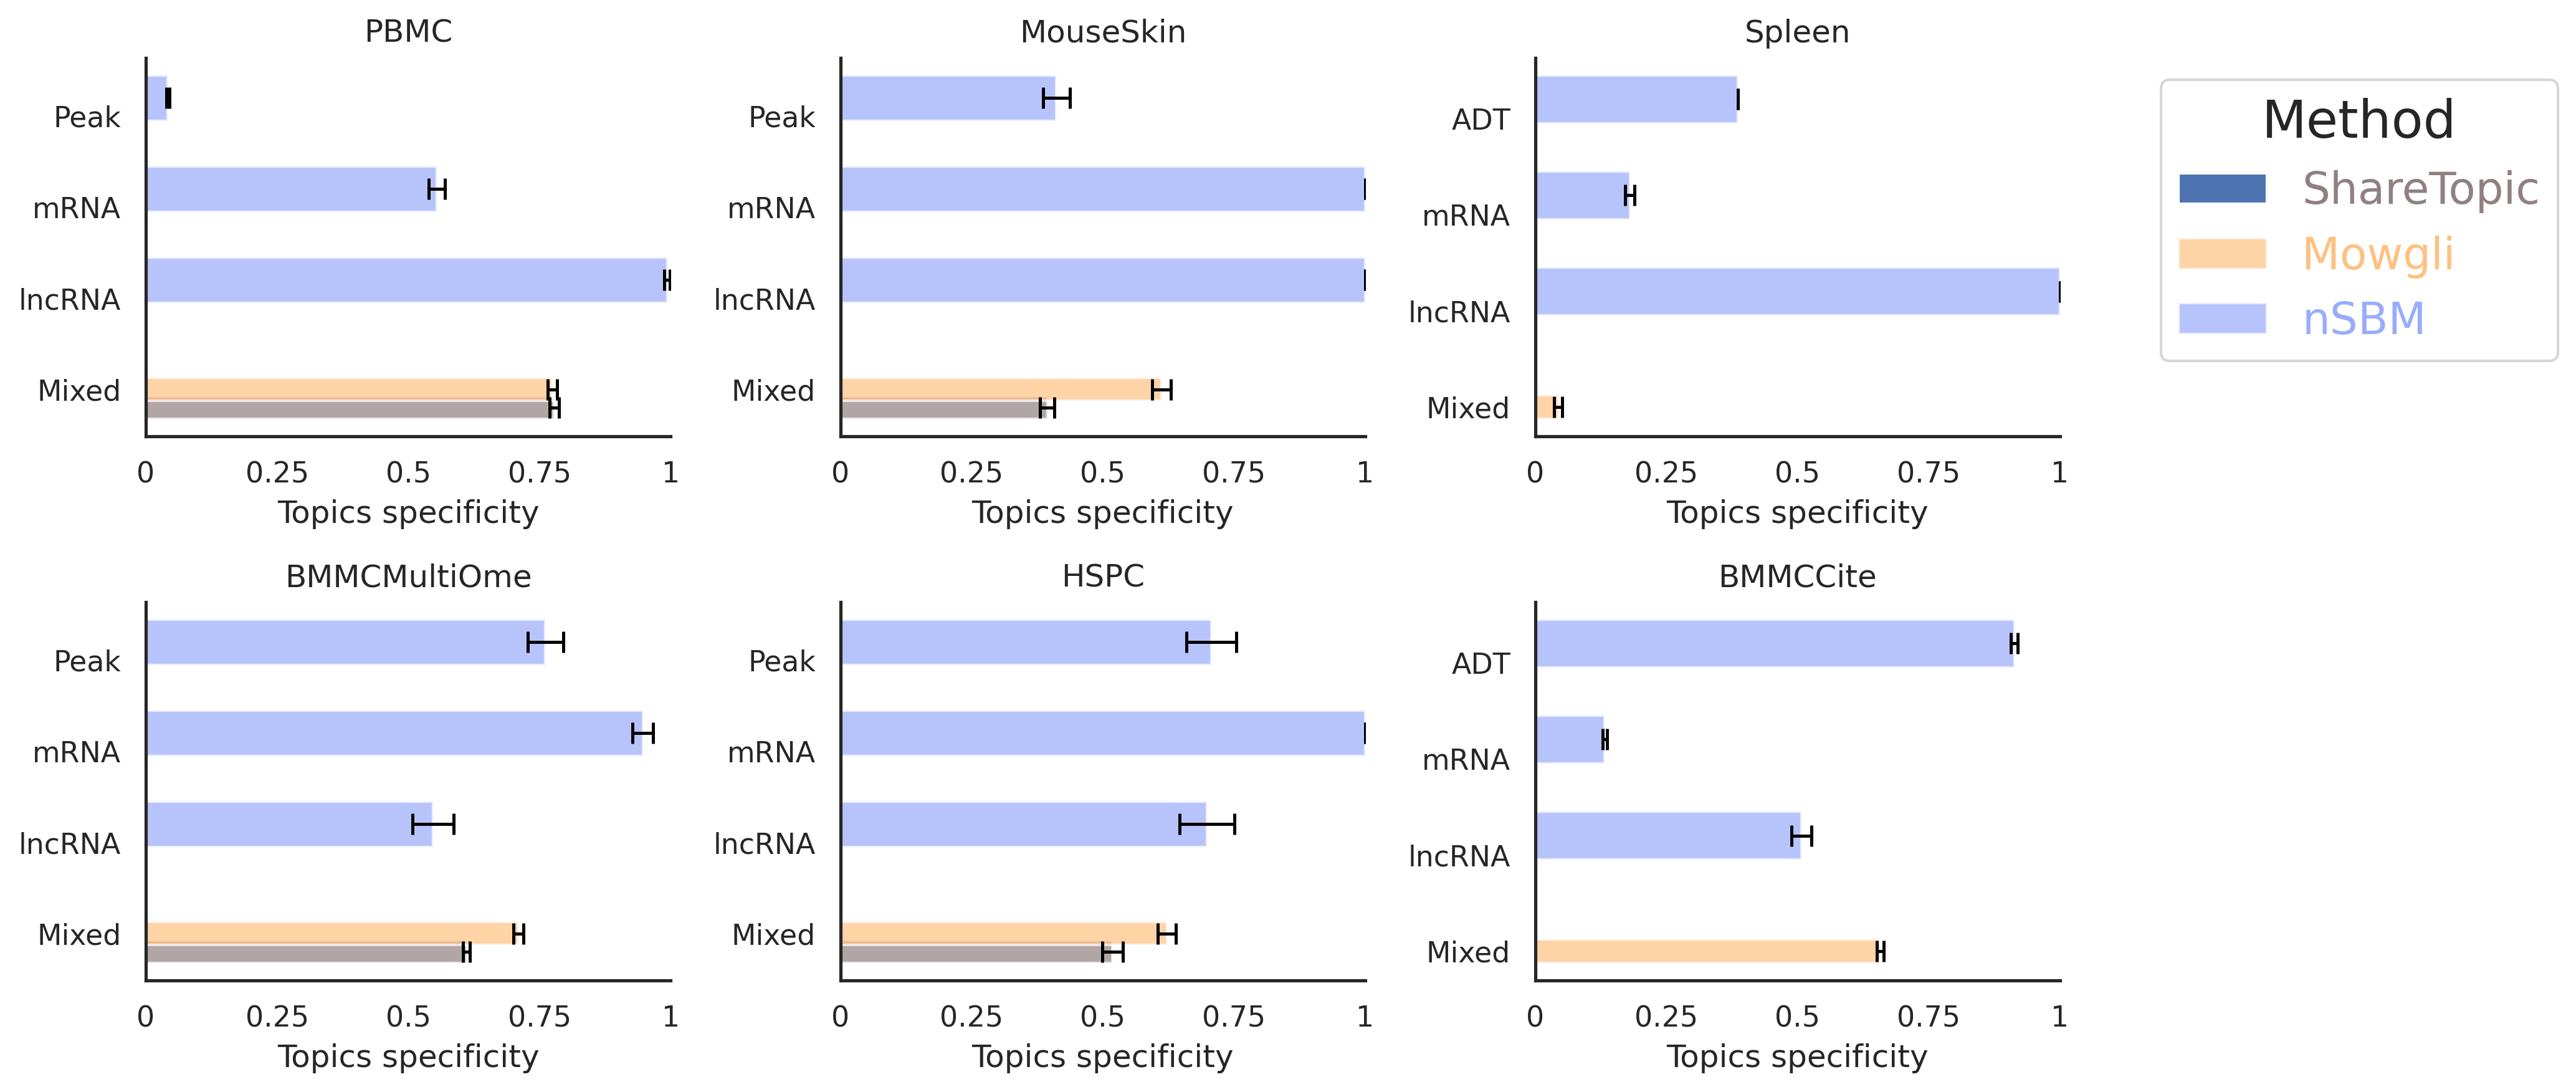

In [32]:
fig, axs = plt.subplots(2, 3, figsize=(14, 6), dpi=300)
axs = axs.flatten()

for l, dataset in enumerate(["PBMC","MouseSkin", "Spleen","BMMCMultiOme","HSPC","BMMCCite"]):
    df = create_results(dataset,exps=["nSBM_Peak_mRNA_lncRNA","Mowgli_Peak_mRNA_lncRNA","ShareTopic_Peak_mRNA",
            "ShareTopic_Peak_lncRNA","nSBM_ADT_mRNA_lncRNA","Mowgli_ADT_mRNA_lncRNA"]).replace({"_" : "+"}, regex=True)
    
    df["Specificty"] = df["DifferentTopics"] / (df["NumberOfCt"] * df["NumberOfTopics"])
    df["Specificty"] = (df["Specificty"] - df["Specificty"].min()) / (df["Specificty"].max() - df["Specificty"].min())

    if dataset in ["BMMCCite", "Spleen"]:
        order = ["ADT", "mRNA", "lncRNA", "Mixed"][::-1]
    else:
        order = ["Peak", "mRNA", "lncRNA", "Mixed"][::-1]

    for i, meth in enumerate(palette.keys()):
        d = df[df["Algorithm"] == meth]

        means = d.groupby("FS")["Specificty"].mean()
        sems  = 3*d.groupby("FS")["Specificty"].sem()

        fs_present = [o for o in order if o in means.index]
        y_positions = np.array([order.index(o) for o in fs_present], dtype=float)
        offset = (i - (len(palette) - 1) / 2) * 0.2
        y_positions += offset

        # Horizontal bar
        height = 0.5 if meth == "nSBM" else 0.25
        axs[l].barh(y_positions,means[fs_present],height=height,color=palette[meth],alpha=0.7,label=meth)

        # Error bars aligned with the bar
        axs[l].errorbar(x=means[fs_present],y=y_positions,xerr=sems[fs_present],fmt='none',
            ecolor='black',elinewidth=1.2,capsize=4,capthick=1.2)
    axs[l].spines['top'].set_visible(False)
    axs[l].spines['right'].set_visible(False)  
    axs[l].spines['bottom'].set_visible(True)
    axs[l].spines['left'].set_visible(True)  
    axs[l].set_title(dataset)
    axs[l].set_xlim([0, 1])
    axs[l].set_yticks(range(len(order)))
    axs[l].set_yticklabels(order)
    axs[l].set_xticks([0,0.25, 0.5, 0.75, 1],["0","0.25", "0.5", "0.75", "1"])

handles, labels = axs[2].get_legend_handles_labels()
axs[2].legend(handles, labels,bbox_to_anchor=(1.15, 1), title="Method",fontsize=17,title_fontsize=20,labelcolor=[palette[key] for key in labels])

for ax in axs:
    ax.set_xlabel("Topics specificity")

fig.tight_layout()
plt.savefig(f"Figures/Figure3.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

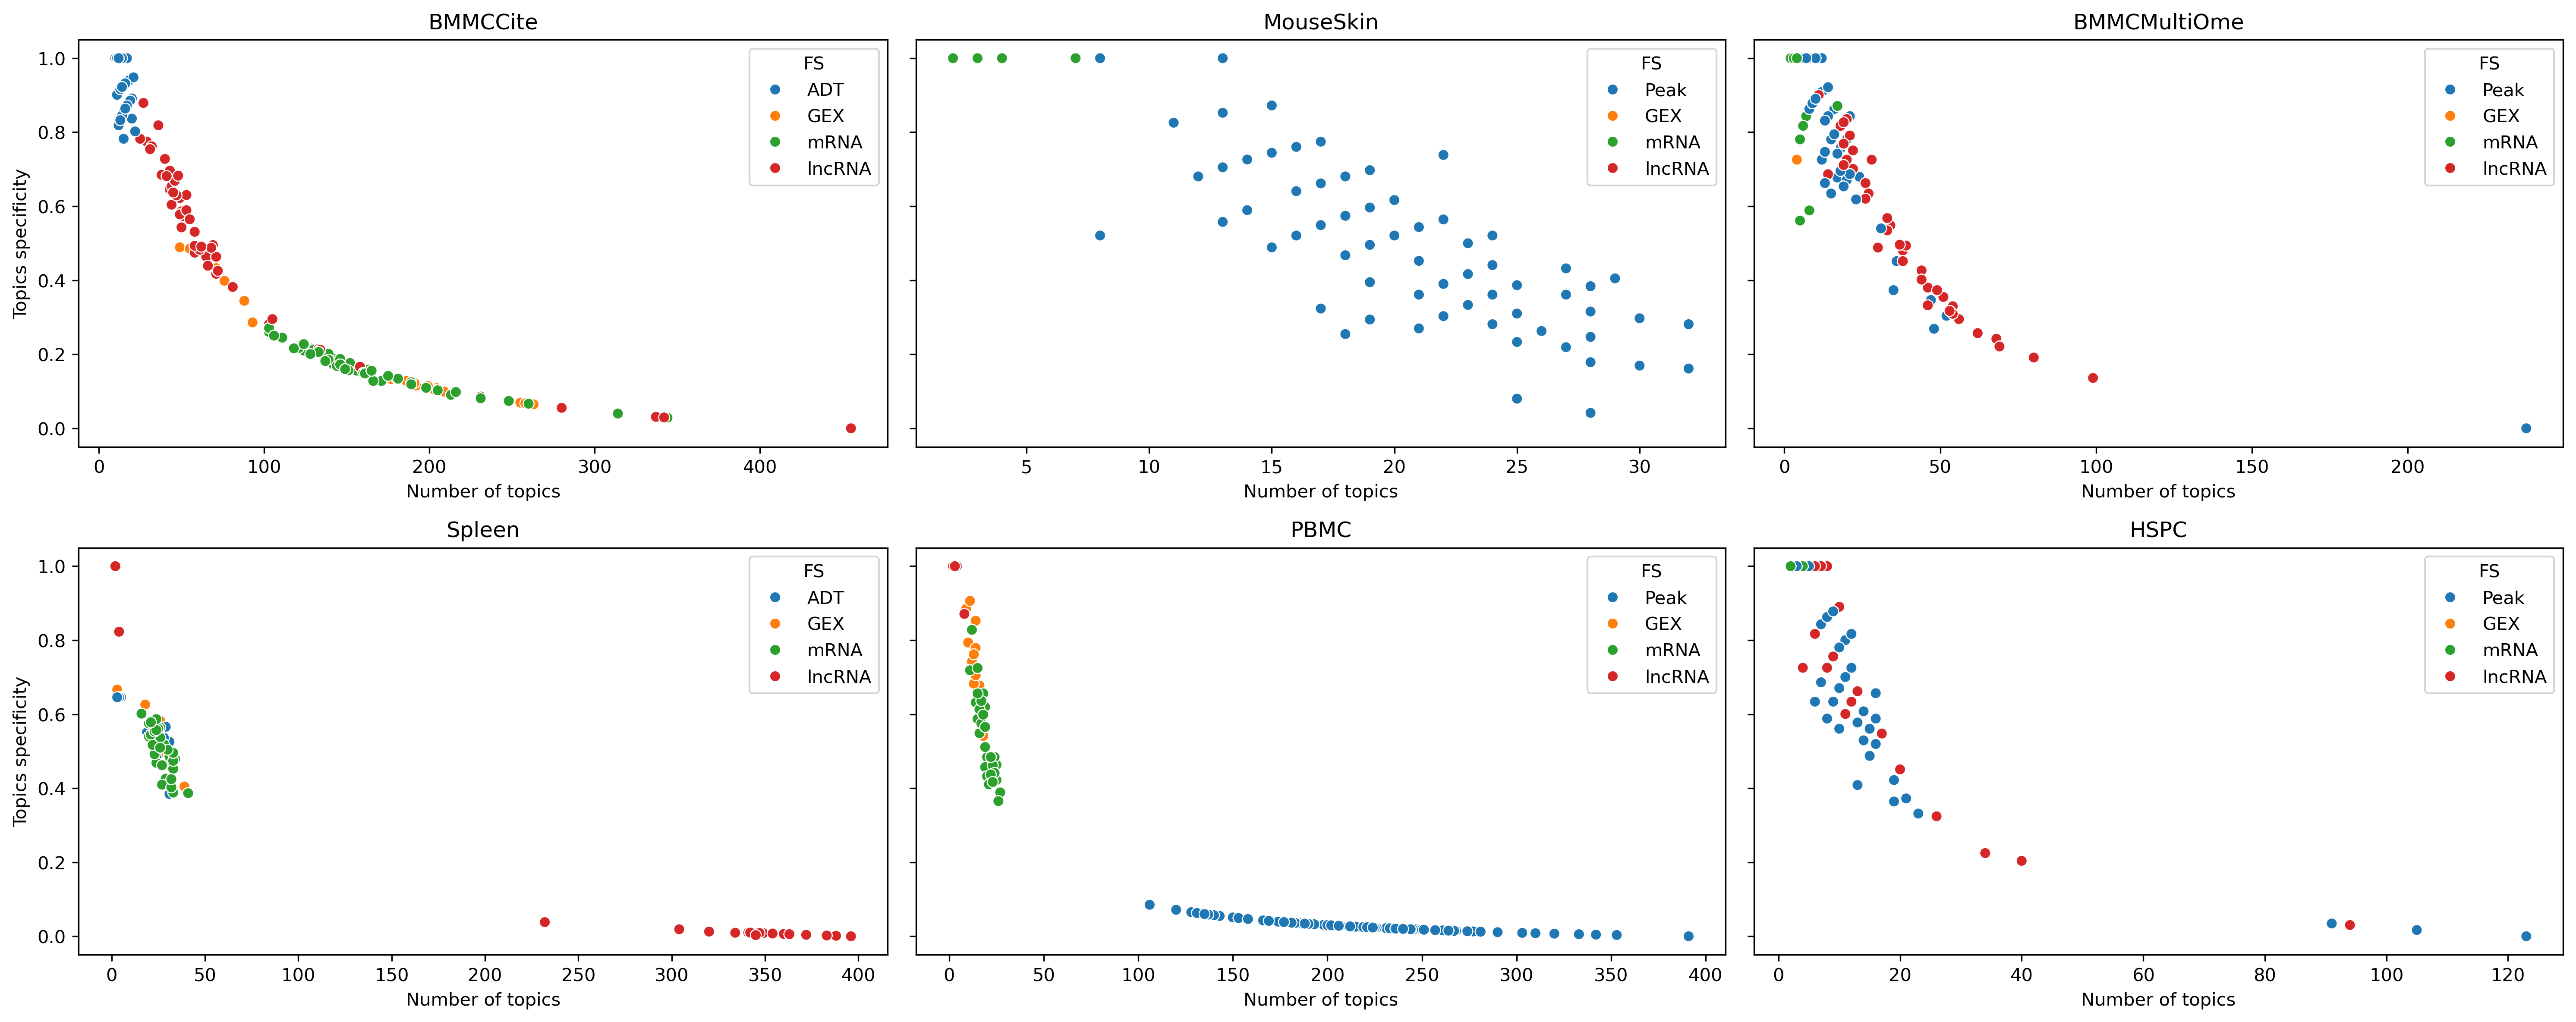

In [191]:
fig, axs = plt.subplots(2,3, figsize=(20,8), dpi=300, sharey=True)
axs=axs.flatten()

for l, dataset in enumerate(["BMMCCite","MouseSkin","BMMCMultiOme", "Spleen", "PBMC","HSPC"]):
    data_def=pd.read_csv(f"Datasets/{dataset}/SBM/{dataset}_SBMs_25Run_TopicsSpec.tsv.gz", sep="\t", index_col=0)
    data_def["Specificty"]=data_def["DifferentTopics"]/(data_def["NumberOfCt"]*data_def["NumberOfTopics"])
    data_def["Specificty"]=(data_def["Specificty"]-data_def["Specificty"].min())/(data_def["Specificty"].max()-data_def["Specificty"].min())
    data_def.head()
    data_def=data_def[data_def["Exp"]!="nSBM_mRNA_lncRNA"]
    sns.scatterplot(data=data_def, x="NumberOfTopics", y="Specificty", hue="FS", ax=axs[l])
    axs[l].set_title(dataset)
    axs[l].set_ylabel("Topics specificity")
    axs[l].set_xlabel("Number of topics")
fig.tight_layout()
plt.show()

### Distinctiveness

In [33]:
fig, axs = plt.subplots(2, 3, figsize=(14, 6), dpi=300)
axs = axs.flatten()

for l, dataset in enumerate(["PBMC","MouseSkin", "Spleen","BMMCMultiOme","HSPC","BMMCCite"]):
    df = create_results(
        dataset,
        exps=[
            "nSBM_Peak_mRNA_lncRNA",
            "Mowgli_Peak_mRNA_lncRNA",
            "ShareTopic_Peak_mRNA",
            "ShareTopic_Peak_lncRNA",
            "nSBM_ADT_mRNA_lncRNA",
            "Mowgli_ADT_mRNA_lncRNA"
        ]
    ).replace({"_" : "+"}, regex=True)
    
    df["Topics_distinctiveness"] = (
        df["Topics_distinctiveness"] - df["Topics_distinctiveness"].min()
    ) / (df["Topics_distinctiveness"].max() - df["Topics_distinctiveness"].min())

    if dataset in ["BMMCCite", "Spleen"]:
        order = ["ADT", "mRNA", "lncRNA", "Mixed"][::-1]
    else:
        order = ["Peak", "mRNA", "lncRNA", "Mixed"][::-1]

    for i, meth in enumerate(palette.keys()):
        d = df[df["Algorithm"] == meth]

        means = d.groupby("FS")["Topics_distinctiveness"].mean()
        sems  = 3*d.groupby("FS")["Topics_distinctiveness"].sem()

        fs_present = [o for o in order if o in means.index]
        y_positions = np.array([order.index(o) for o in fs_present], dtype=float)
        offset = (i - (len(palette) - 1) / 2) * 0.2
        y_positions += offset

        # Horizontal bar
        height = 0.5 if meth == "nSBM" else 0.25
        axs[l].barh(y_positions,means[fs_present],height=height,color=palette[meth],alpha=0.7,label=meth)

        # Error bars aligned with the bar
        axs[l].errorbar(x=means[fs_present],y=y_positions,xerr=sems[fs_present],fmt='none',ecolor='black',elinewidth=1.2,capsize=4,capthick=1.2)
        
    axs[l].spines['top'].set_visible(False)
    axs[l].spines['right'].set_visible(False)  
    axs[l].spines['bottom'].set_visible(True)
    axs[l].spines['left'].set_visible(True)  
    axs[l].set_title(dataset)
    axs[l].set_xlim([0, 1])
    axs[l].set_yticks(range(len(order)))
    axs[l].set_yticklabels(order)
    axs[l].set_xticks([0,0.25, 0.5, 0.75, 1],["0","0.25", "0.5", "0.75", "1"])

handles, labels = axs[2].get_legend_handles_labels()
axs[2].legend(handles, labels,bbox_to_anchor=(1.15, 1), title="Method",fontsize=17,title_fontsize=20,labelcolor=[palette[key] for key in labels])

for ax in axs:
    ax.set_xlabel("Topics distinctiveness")

fig.tight_layout()
plt.savefig(f"Figures/Figure4.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

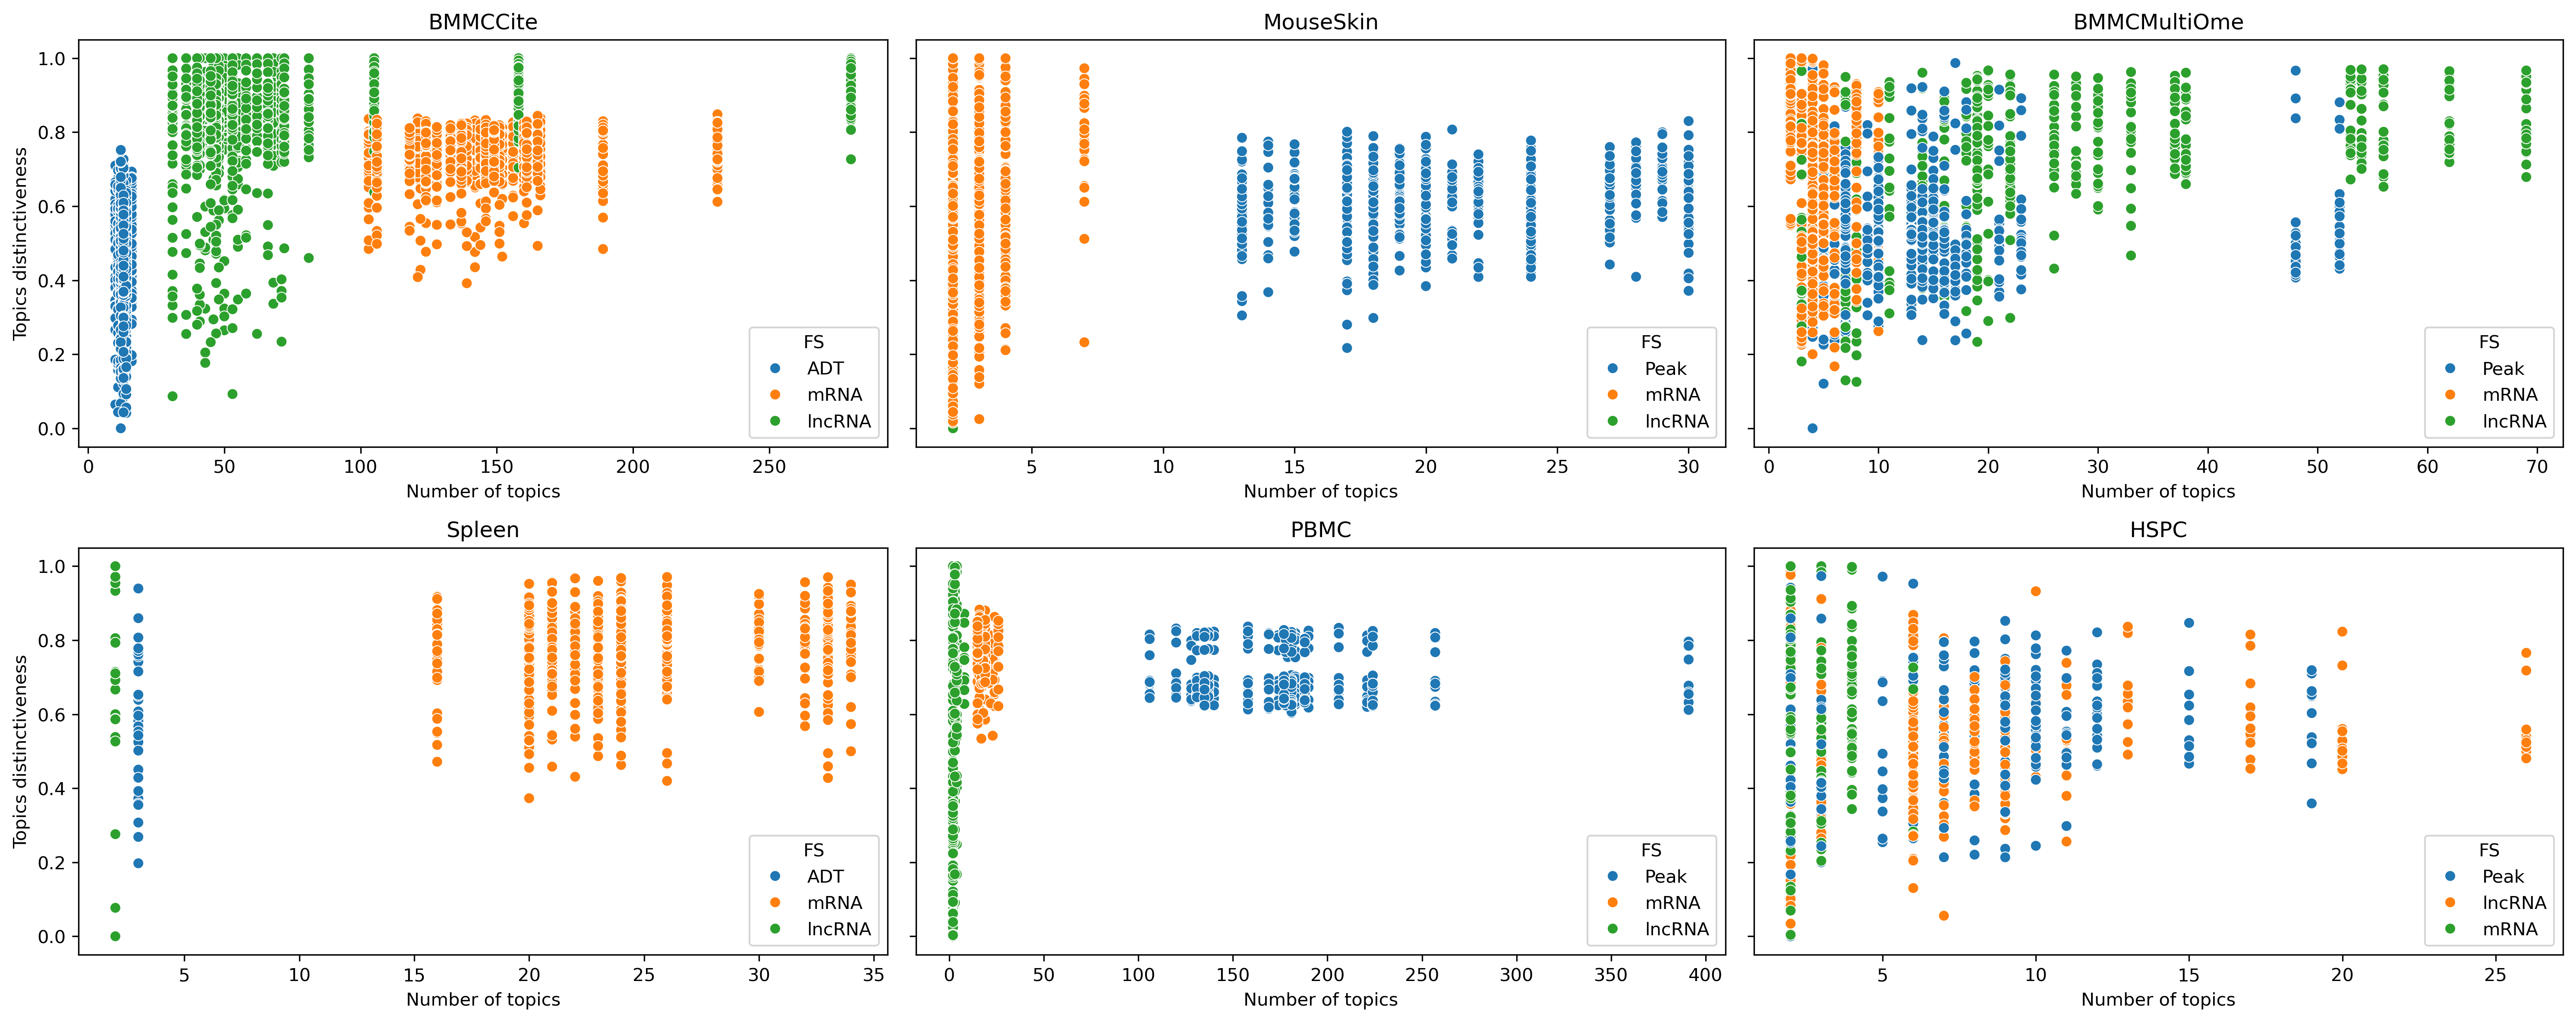

In [15]:
fig, axs = plt.subplots(2,3, figsize=(20,8), dpi=300, sharey=True)
axs=axs.flatten()

for l, dataset in enumerate(["BMMCCite","MouseSkin","BMMCMultiOme", "Spleen", "PBMC","HSPC"]):
    data_def=pd.read_csv(f"Datasets/{dataset}/SBM/{dataset}_SBMs_25Run_TopicsSpec.tsv.gz", sep="\t", index_col=0)
    exps=["nSBM_Peak_mRNA_lncRNA","Mowgli_Peak_mRNA_lncRNA","ShareTopic_Peak_GEX", "nSBM_ADT_mRNA_lncRNA","Mowgli_ADT_mRNA_lncRNA"]
    data_def=data_def[data_def.Exp.isin(exps)]
    data_def["Topics_distinctiveness"]=(data_def["Topics_distinctiveness"]-data_def["Topics_distinctiveness"].min())/(data_def["Topics_distinctiveness"].max()-data_def["Topics_distinctiveness"].min())
    data_def.head()
    data_def=data_def[data_def["Exp"]!="nSBM_mRNA_lncRNA"]
    sns.scatterplot(data=data_def, x="NumberOfTopics", y="Topics_distinctiveness", hue="FS", ax=axs[l])
    axs[l].set_title(dataset)
    axs[l].set_ylabel("Topics distinctiveness")
    axs[l].set_xlabel("Number of topics")
fig.tight_layout()
plt.show()

In [11]:
exps=["nSBM_Peak_mRNA_lncRNA","Mowgli_Peak_mRNA_lncRNA","ShareTopic_Peak_GEX", "nSBM_ADT_mRNA_lncRNA","Mowgli_ADT_mRNA_lncRNA"]


# Peaks topics Annotations

In [3]:
annots=["lncRNA","promoter","protein_coding","miRNA","tRNA","rRNA","LINE","SINE"]
for dataset in ["PBMC","MouseSkin","BMMCMultiOme","HSPC"]:
    data=pd.read_csv(f"Datasets/{dataset}/SBM/{dataset}_SBMs_25Run.tsv.gz", sep="\t", index_col=0)
    adata=sc.read_h5ad(f"Datasets/{dataset}/CM/{dataset}_Peak_Def_Annot.h5ad")
    data_def = pd.DataFrame(columns=["Dataset","Exp","Run","Homo","HomoSEM"])
    exps_nSBM = ["nSBM_Peak_GEX", "nSBM_Peak_mRNA", "nSBM_Peak_lncRNA", "nSBM_Peak_mRNA_lncRNA"]
    for exp in exps_nSBM:
        print(dataset, exp)
        for run in range(0, 25):
            exps_levels={}
            for level in range(0,6):
                if f"{exp}_Level_{level}_Run_{run}" in data.columns:
                    exps_levels[level]=np.abs(len(set(data[f"{exp}_Level_{level}_Run_{run}"].dropna()))-len(set(data["CellType"].dropna())))
            if bool(exps_levels) != False:
                min_level=np.argmin(pd.DataFrame.from_dict(exps_levels, orient="index").fillna(10000000000))
                file = f"Datasets/{dataset}/SBM/{exp}/Runs/Run{run}/{dataset}_{exp}_level_{min_level}_Peak_topics.csv.gz"
                if os.path.isfile(file):
                    df=pd.read_csv(file, index_col=0)
                    table=pd.DataFrame(index=annots)
                    for col in df.columns:
                        table[col]=adata.var.loc[list(df.index[df[col]>0])][annots].sum(axis=0)
                    table=table.T/np.array(pd.DataFrame.from_dict(adata.uns["AnnotNorm"], orient="index").loc[annots][0])
                    table=table.T
                    homos=np.array([np.mean(table[col].sort_values()[::-1][1:]) for col in table.columns])/table.max(axis=0)
                    homo_mean=np.mean(homos)
                    homo_sem=np.std(homos)/np.sqrt(len(homos))
                    d=pd.DataFrame(data=[dataset,exp,run, homo_mean, homo_sem], index=data_def.columns).T
                    data_def=pd.concat([data_def,d],axis=0)
    data_def.to_csv(f"Datasets/{dataset}/SBM/{dataset}_SBMs_25Run_TopicsAnnotQuantification.tsv.gz", sep="\t", compression="gzip")

PBMC nSBM_Peak_GEX
PBMC nSBM_Peak_mRNA
PBMC nSBM_Peak_lncRNA
PBMC nSBM_Peak_mRNA_lncRNA
MouseSkin nSBM_Peak_GEX
MouseSkin nSBM_Peak_mRNA
MouseSkin nSBM_Peak_lncRNA
MouseSkin nSBM_Peak_mRNA_lncRNA
BMMCMultiOme nSBM_Peak_GEX
BMMCMultiOme nSBM_Peak_mRNA
BMMCMultiOme nSBM_Peak_lncRNA
BMMCMultiOme nSBM_Peak_mRNA_lncRNA
HSPC nSBM_Peak_GEX
HSPC nSBM_Peak_mRNA
HSPC nSBM_Peak_lncRNA
HSPC nSBM_Peak_mRNA_lncRNA


In [78]:
dfs=pd.DataFrame(data=["MouseSkin", "BMMCMultiOme", "PBMC","HSPC"])
hs1="../AnnotRef/hs/T2T/BEDFiles/T2T"
hg38="../AnnotRef/hs/hg38/BEDFiles/hg38"
mm10="../AnnotRef/mm/BEDFiles/mm10"
dfs["AnnotsPath"]=[mm10, hg38, hs1, hg38]
annots=["lncRNA","promoter","protein_coding","miRNA","tRNA","rRNA","LINE","SINE"]
dfs

0                         AnnotsPath
0     MouseSkin       ../AnnotRef/mm/BEDFiles/mm10
1  BMMCMultiOme  ../AnnotRef/hs/hg38/BEDFiles/hg38
2          PBMC    ../AnnotRef/hs/T2T/BEDFiles/T2T
3          HSPC  ../AnnotRef/hs/hg38/BEDFiles/hg38

In [74]:
all_data=pd.DataFrame(columns=["Annotation","Prevalence [AU]","Dataset"])
for dataset, annots_path, job in zip(dfs[0], dfs["AnnotsPath"], ["Pb","Br","Bm","Hs"]):  
    adata=sc.read_h5ad(f"Datasets/{dataset}/CM/{dataset}_Peak_Def_Annot.h5ad")
    norms={}
    for annot in annots:
        n=pd.read_csv(f"{annots_path}_{annot}.bed", sep="\t", header=None)
        norms[annot]=np.sum(n[2]-n[1])
    norms=pd.DataFrame.from_dict(norms, orient="index").loc[adata.var[annots].sum().index]
    data=pd.DataFrame(adata.var[annots].sum()/norms[0]*10000, columns=["Prevalence [AU]"]).astype(int).reset_index()
    data["Dataset"]=dataset
   # data=data.sort_values(by="Prevalence [AU]")
    data.rename({"index":"Annotation"}, axis=1, inplace=True)
    all_data=pd.concat([all_data, data])

In [77]:
fig, axs = plt.subplots(2,2, dpi=300, figsize=(12,6))
axs=axs.flatten()
for l,dataset in enumerate(set(all_data["Dataset"])):
    print(l)
    d=all_data[all_data["Dataset"]==dataset]
    d=d.sort_values(by="Prevalence [AU]")
    axs[l].barh(width=d["Prevalence [AU]"], y=d["Annotation"])
    axs[l].set_xlabel("Prevalence [AU]")
    axs[l].set_title(dataset)
plt.tight_layout()
plt.show()

0
1
2
3


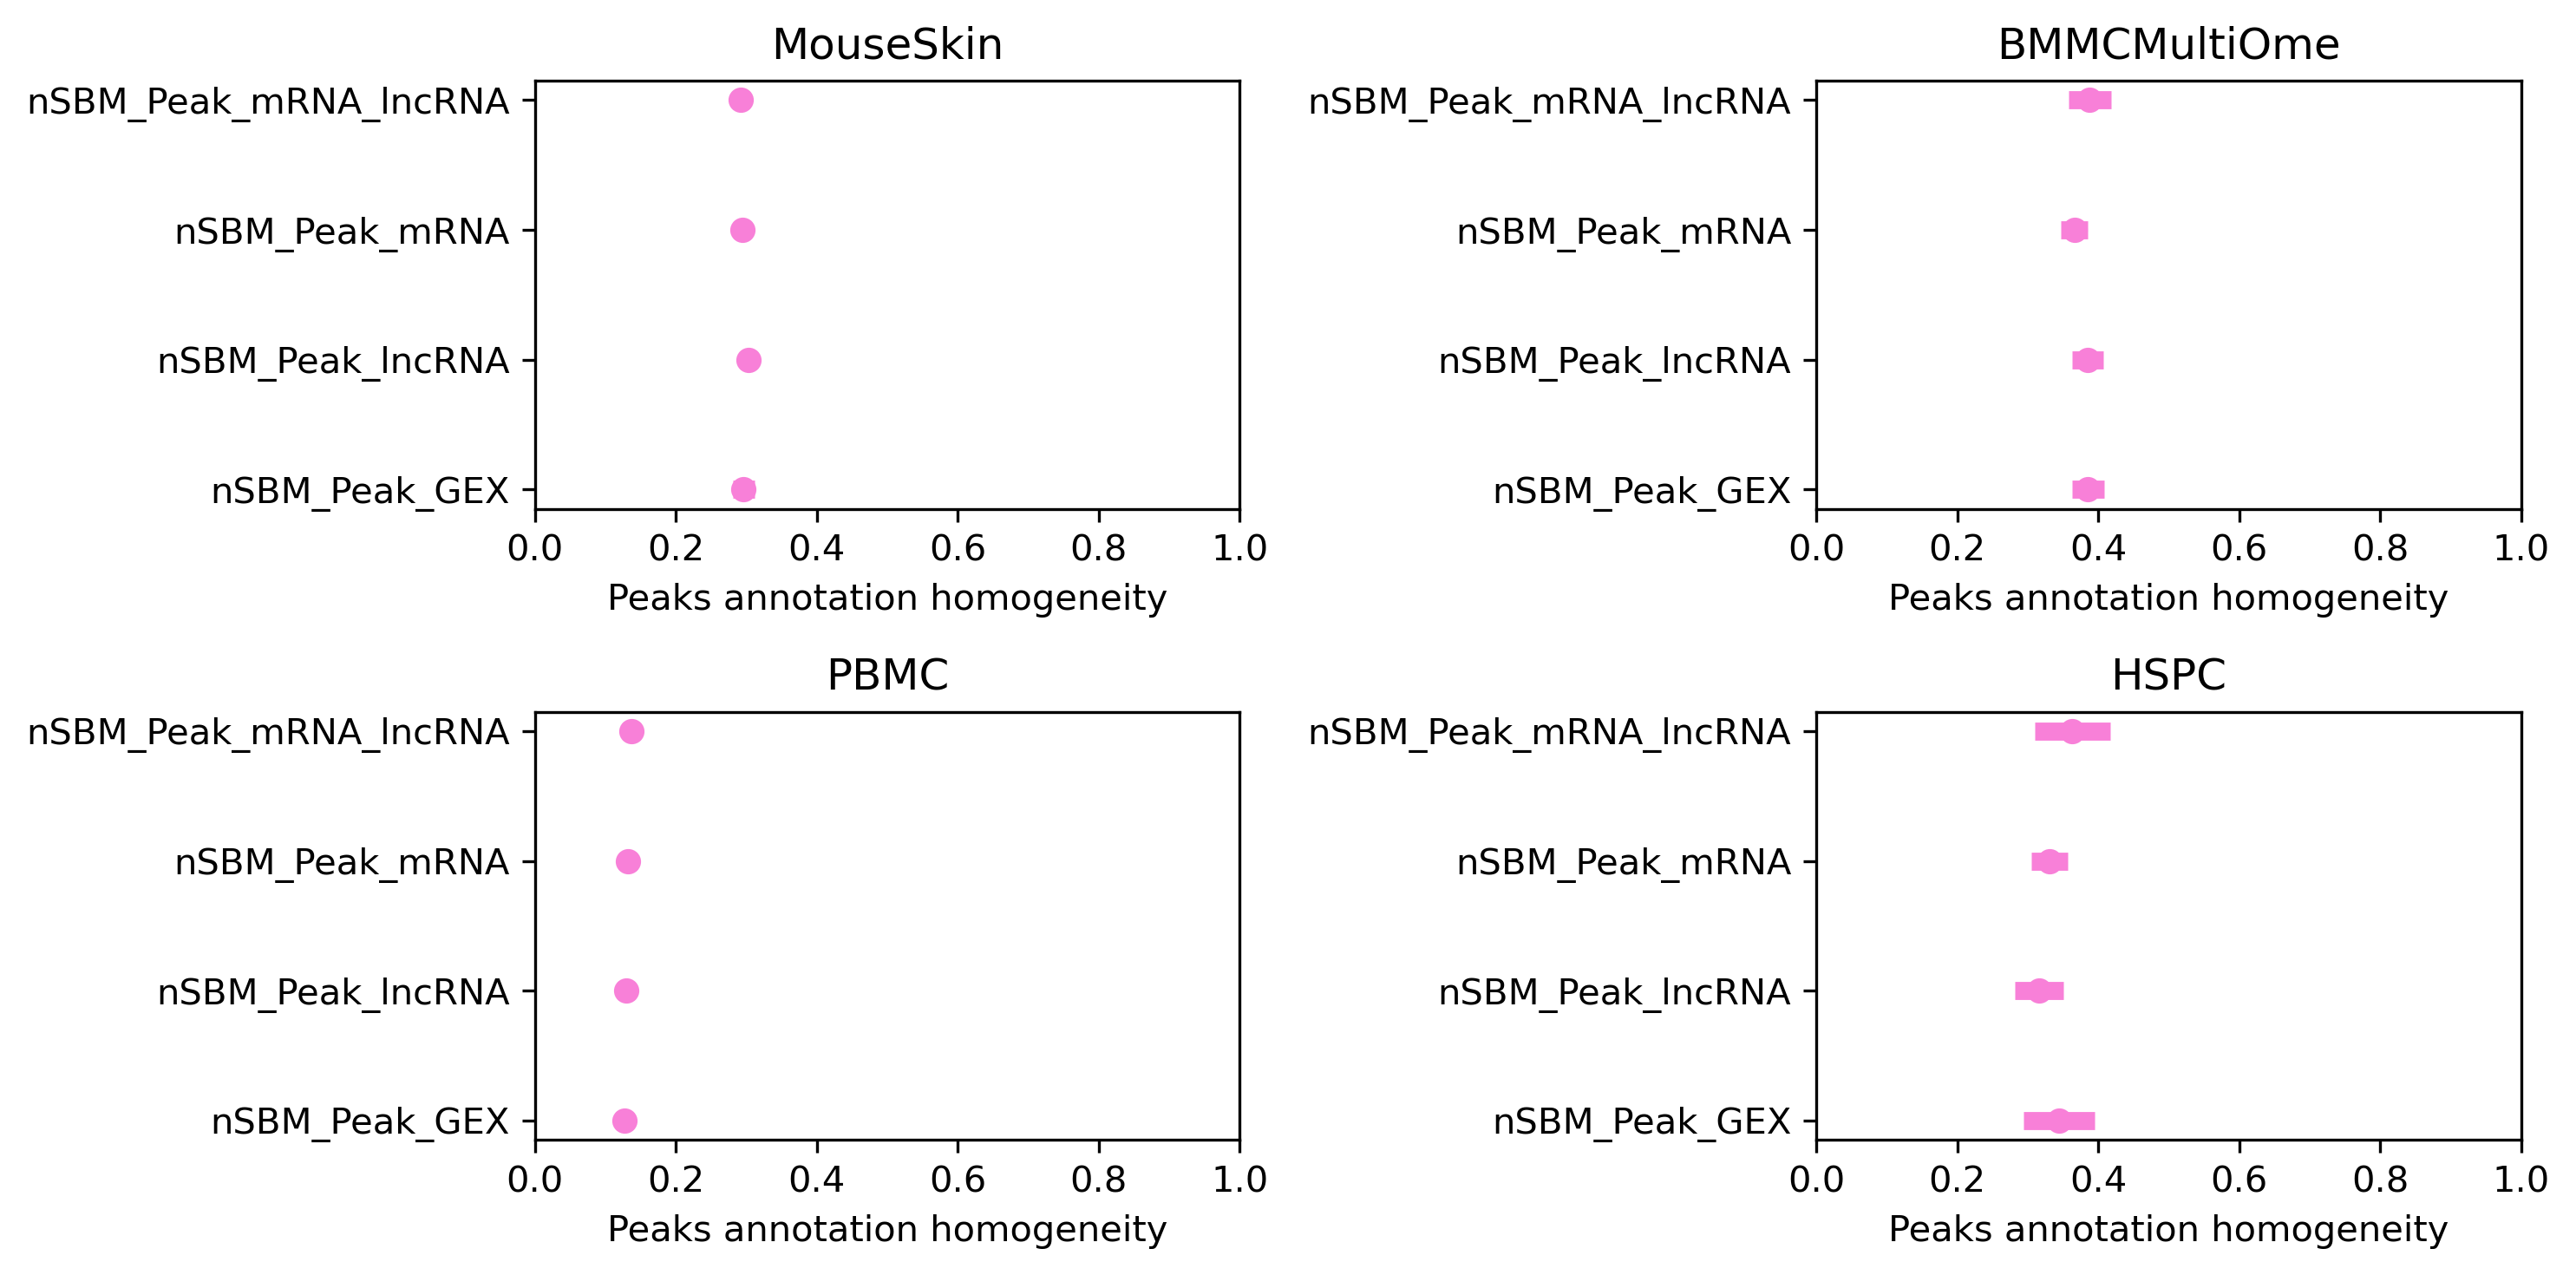

In [72]:
fig, axs = plt.subplots(2,2, figsize=(10,5), dpi=300)
axs=axs.flatten()

for l, dataset in enumerate(["MouseSkin","BMMCMultiOme", "PBMC","HSPC"]):
    d=df[df["Dataset"]==dataset]
    means=np.array(d.groupby("Exp")["Homo"].mean())
    sems=3*np.array(d.groupby("Exp")["Ratio"].sem())
    x=np.array(pd.DataFrame(data=[means, sems], columns=order, index=["mean","sem"]).T.loc[order]["mean"])
    xerr=np.array(pd.DataFrame(data=[means, sems], columns=order, index=["mean","sem"]).T.loc[order]["sem"])
    axs[l].errorbar(x=x, y=order, xerr=xerr, ls='none', ecolor=colors_to_use_pastel[-1], 
                    elinewidth=5, marker="o", c=colors_to_use_pastel[-1])

    axs[l].set_title(dataset)
    axs[l].set_xlim([0, 1])
#handles, labels = axs[2].get_legend_handles_labels()
#axs[2].legend(handles, labels, bbox_to_anchor=(1.15, 1), title="Method", fontsize=17,  
 #             title_fontsize=20, labelcolor=[palette[key] for key in labels])
for ax in axs:
    ax.set_xlabel("Peaks annotation homogeneity")
fig.tight_layout()
plt.savefig(f"Figures/AllMethods_Topics_Annotations.png", format="png", dpi=300, bbox_inches='tight')
plt.show()